# 1. Import Required Lib

In [24]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle
import random
import pdb
from torch.utils.data import DataLoader
import logging
import itertools
import unicodedata
import string
import re
import random
import argparse
from torch import optim
import time
import os
from bleu_score import BLEU_SCORE
# from models_viet import EncoderRNN, AttentionDecoderRNN, DecoderRNN
from load_dataset_es_sample import *
# from define_training_viet import *
# import torchtext
from torch.utils.data import BatchSampler
from torch.utils.data import SequentialSampler
from torch.utils.data import Sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy
# import seaborn

In [25]:
print(torch.version)

<module 'torch.version' from '/home/brs426/py3.6.3/lib/python3.6/site-packages/torch/version.py'>


In [26]:
device = torch.device('cpu')
print(device)

cpu


# Important flag to be set

In [27]:
# set to true when English to intermediate language
# set to false when intermediate language to English
is_english_first = True

# 2. Build data loaders

## Note : Dataloader class should always return the below. eg: intermediate = Viet
#### return [viet, english, vi_len, en_len,....]

In [28]:
class Summerization(Dataset):
    def __init__(self, df, val = False):
        self.df = df
        self.val = val
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        english = self.df.iloc[idx,:]['en_idized']
        viet = self.df.iloc[idx,:]['vi_idized']
        en_len = self.df.iloc[idx,:]['en_len']
        vi_len = self.df.iloc[idx,:]['vi_len']
        if self.val:
            en_data = self.df.iloc[idx,:]['en_data'].lower()
            vi_data = self.df.iloc[idx,:]['vi_data'].lower()
            
            if is_english_first:
                return [viet, english, vi_len, en_len, vi_data]
            else:
                return [viet, english, vi_len, en_len, en_data]
        else:
            return [viet, english, vi_len, en_len]
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    


def convert_idx_2_sent(tensor, lang_obj):
    word_list = []
    for i in tensor:
        if i.item() not in set([PAD_IDX,EOS_token,SOS_token]):
            word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

def convert_id_list_2_sent(list_idx, lang_obj):
    word_list = []
    if type(list_idx) == list:
        for i in list_idx:
            if i not in set([EOS_token]):
                word_list.append(lang_obj.index2word[i])
    else:
        for i in list_idx:
            if i.item() not in set([EOS_token,SOS_token,PAD_IDX]):
                word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

In [29]:
def vocab_collate_func(batch):
    MAX_LEN_EN = 48
    MAX_LEN_VI = 48
    en_data = []
    vi_data = []
    en_len = []
    vi_len = []
    for datum in batch:
        en_len.append(datum[3])
        vi_len.append(datum[2])
    max_batch_length_en = max(en_len)
    max_batch_length_vi = max(vi_len)
    if max_batch_length_en < MAX_LEN_EN:
        MAX_LEN_EN = max_batch_length_en
    if max_batch_length_vi < MAX_LEN_VI:
        MAX_LEN_VI = max_batch_length_vi
    # padding
    for datum in batch:
        if datum[2]>MAX_LEN_VI:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN_VI]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN_VI - datum[2])),
                                mode="constant", constant_values=PAD_IDX)
        if datum[3]>MAX_LEN_EN:
            padded_vec_s2 = np.array(datum[1])[:MAX_LEN_EN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_LEN_EN - datum[3])),
                                mode="constant", constant_values=PAD_IDX)
        en_data.append(padded_vec_s2)
        vi_data.append(padded_vec_s1)
    vi_data = np.array(vi_data)
    en_data = np.array(en_data)
    vi_len = np.array(vi_len)
    en_len = np.array(en_len)
    vi_len[vi_len>MAX_LEN_VI] = MAX_LEN_VI
    en_len[en_len>MAX_LEN_EN] = MAX_LEN_EN
        
    if is_english_first:
        return [torch.from_numpy(en_data),torch.from_numpy(vi_data), 
            torch.from_numpy(en_len), torch.from_numpy(vi_len)]
    else:
        return [torch.from_numpy(vi_data), torch.from_numpy(en_data),
            torch.from_numpy(vi_len), torch.from_numpy(en_len)]


In [30]:
if is_english_first:
    def vocab_collate_func_val(batch):
        return [torch.from_numpy(np.array(batch[0][1])).unsqueeze(0), torch.from_numpy(np.array(batch[0][0])).unsqueeze(0), 
            torch.from_numpy(np.array(batch[0][3])).unsqueeze(0), torch.from_numpy(np.array(batch[0][2])).unsqueeze(0),batch[0][4]]

else:
    def vocab_collate_func_val(batch):
        return [torch.from_numpy(np.array(batch[0][0])).unsqueeze(0), torch.from_numpy(np.array(batch[0][1])).unsqueeze(0),
            torch.from_numpy(np.array(batch[0][2])).unsqueeze(0), torch.from_numpy(np.array(batch[0][3])).unsqueeze(0),batch[0][4]]
    


### Note : train_val_load(48, "", '../../machine_translation/') should always return the below. Eg: intermediate = viet

#### train, val, test, en, vi = train_val_load(48, "", '../../machine_translation/')

In [31]:
if is_english_first:
    train, val, test, second_lang, first_lang = train_val_load(48, "", '../../../scratch/brs426')
else:
    train, val, test, first_lang, second_lang = train_val_load(48, "", '../../../scratch/brs426')

reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
Created pickle
Finished lambda training functions
Finished lambda validation functions
Finished test lambda functions


In [32]:
def shuffle_sorted_batches(train, bs):
    batch_samp_list = list(BatchSampler(SequentialSampler(train), bs, drop_last = False))
    np.random.shuffle(batch_samp_list)
    batch_samp_list_merged = list(itertools.chain(*batch_samp_list))
    return train.iloc[batch_samp_list_merged,:]

In [33]:
train.head()

,en_data,vi_data,en_tokenized,vi_tokenized,en_idized,vi_idized,en_len,vi_len
0,I would be pleased to come to the Commission o...,Estoy dispuesto a ir el lunes por la mañana a ...,"[i, would, be, pleased, to, come, to, the, com...","[estoy, dispuesto, a, ir, el, lunes, por, la, ...","[18, 26, 13, 761, 5, 198, 5, 4, 38, 17, 2, 111...","[80, 2, 16, 790, 5, 2, 22, 4, 312, 16, 4, 32, ...",19,18
1,"Nevertheless , I believe that it would be wron...","Sin embargo , considero que sería error si cul...","[nevertheless, ,, i, believe, that, it, would,...","[sin, embargo, ,, considero, que, sería, error...","[593, 9, 18, 85, 7, 15, 26, 13, 1151, 8, 122, ...","[60, 166, 9, 478, 6, 371, 2, 74, 2, 2, 16, 4, ...",43,37
2,Amendment No 13 ensures that the link between ...,La enmienda 13 procura que la vinculación entr...,"[amendment, no, 13, ensures, that, the, link, ...","[la, enmienda, 13, procura, que, la, vinculaci...","[228, 184, 2, 2, 7, 4, 2, 148, 2, 11, 2, 14, 2...","[4, 236, 2, 2, 6, 4, 2, 85, 5, 2, 11, 5, 2, 2,...",15,17
3,Let us not confuse the need for a common frame...,No confundamos la necesidad de un marco común ...,"[let, us, not, confuse, the, need, for, a, com...","[no, confundamos, la, necesidad, de, un, marco...","[318, 122, 19, 2, 4, 45, 22, 12, 140, 254, 23,...","[18, 2, 4, 322, 8, 17, 196, 148, 20, 5, 2, 7, 1]",14,13
4,We were among the few who said that we could n...,Nos contamos entre los pocos que dijeron que n...,"[we, were, among, the, few, who, said, that, w...","[nos, contamos, entre, los, pocos, que, dijero...","[16, 177, 197, 4, 339, 68, 325, 7, 16, 303, 19...","[88, 2, 85, 12, 1108, 6, 2, 6, 18, 2, 21, 276,...",30,27


In [34]:
bs_dict = {'train':128,'validate':1, 'train_val':1,'val_train':128, 'test':1}
shuffle_dict = {'train':True,'validate':False, 'train_val':False,'val_train':True, 'test':False}
# train_used = shuffle_sorted_batches(train_sorted, bs_dict['train'])
# train_used = train.sample(n=100)
# val_used = val.sample(n=50)

train_used = train
val_used = val

collate_fn_dict = {'train':vocab_collate_func, 'validate':vocab_collate_func_val,\
                   'train_val':vocab_collate_func_val,'val_train':vocab_collate_func,'test': vocab_collate_func_val}
transformed_dataset = {'train': Summerization(train_used),
                       'validate': Summerization(val_used, val = True),
                       'train_val':Summerization(train.iloc[:50], val = True),
                       'val_train':Summerization(val_used),
                       'test':Summerization(test, val= True)
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs_dict[x], collate_fn=collate_fn_dict[x],
                    shuffle=shuffle_dict[x], num_workers=0) for x in ['train', 'validate', 'train_val','val_train', 'test']}

# 3. Build Models

In [59]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_size,n_layers, rnn_type = 'lstm', device = 'cpu'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = Embedding(input_size, embed_dim, PAD_IDX)
        self.rnn_type =  rnn_type
        self.dropout_in = nn.Dropout(p = 0.1)
        self.n_layers = n_layers
        self.device = device
        if rnn_type == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_size,batch_first=True,bidirectional=True, num_layers = self.n_layers, dropout = 0.2)
        elif rnn_type == 'lstm':
            self.rnn = LSTM(embed_dim, hidden_size, batch_first=True,bidirectional=True, num_layers = n_layers,dropout = 0.2)

    def forward(self, enc_inp, src_len):
        sorted_idx = torch.sort(src_len, descending=True)[1]
        orig_idx = torch.sort(sorted_idx)[1]
        embedded = self.embedding(enc_inp)
        bs = embedded.size(0)
        output = self.dropout_in(embedded)
        if self.rnn_type == 'gru':
            hidden =  self.initHidden(bs)
            sorted_output = output[sorted_idx]
            sorted_len = src_len[sorted_idx]
            packed_output = nn.utils.rnn.pack_padded_sequence(sorted_output, sorted_len.data.tolist(), batch_first = True)
            packed_outs, hiddden = self.rnn(packed_output,(hidden, c))
            hidden = hidden[:,orig_idx,:]
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_outs, padding_value=PAD_IDX, batch_first = True)
            output = output[orig_idx]
            hidden = hidden.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            return output, hidden, hidden
        elif self.rnn_type == 'lstm':
            hidden, c = self.initHidden(bs)
            sorted_output = output[sorted_idx]
            sorted_len = src_len[sorted_idx]
            packed_output = nn.utils.rnn.pack_padded_sequence(sorted_output, sorted_len.data.tolist(), batch_first = True)
            packed_outs, (hiddden, c) = self.rnn(packed_output,(hidden, c))
            hidden = hidden[:,orig_idx,:]
            c = c[:,orig_idx,:]
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_outs, padding_value=PAD_IDX, batch_first = True)
            output = output[orig_idx]
            c = c.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            hidden = hidden.view(self.n_layers, 2, bs, -1).transpose(1, 2).contiguous().view(self.n_layers, bs, -1)
            return output, hidden, c
        
    def initHidden(self,bs):
        if self.rnn_type == 'gru' :
            return torch.zeros(self.n_layers*2, bs, self.hidden_size).to(self.device)
        elif self.rnn_type == 'lstm':
            return torch.zeros(self.n_layers*2,bs,self.hidden_size).to(self.device),torch.zeros(self.n_layers*2,bs,self.hidden_size).to(self.device)

class Attention_Module(nn.Module):
    def __init__(self, hidden_dim, output_dim, device = 'cpu'):
        super(Attention_Module, self).__init__()
        self.l1 = Linear(hidden_dim, output_dim, bias = False)
        self.l2 = Linear(hidden_dim+output_dim, output_dim, bias =  False)
        self.device = device
        
    def forward(self, hidden, encoder_outs, src_lens):
        ''' hiddden: bsz x hidden_dim
        encoder_outs: bsz x sq_len x encoder dim (output_dim)
        src_lens: bsz
        
        x: bsz x output_dim
        attn_score: bsz x sq_len'''
        print("in attention")
        x = self.l1(hidden)
        att_score = (encoder_outs.transpose(0,1) * x.unsqueeze(0)).sum(dim = 2)
        seq_mask = sequence_mask(src_lens, max_len = max(src_lens).item(), device = self.device).transpose(0,1)
        masked_att = seq_mask*att_score
        masked_att[masked_att==0] = -1e10
        attn_scores = F.softmax(masked_att, dim=0)
        x = (attn_scores.unsqueeze(2) * encoder_outs.transpose(0,1)).sum(dim=0)
        x = torch.tanh(self.l2(torch.cat((x, hidden), dim=1)))
        return x, attn_scores
        
class AttentionDecoderRNN(nn.Module):
    def __init__(self, output_size, embed_dim, hidden_size, n_layers = 1, attention = True, device = 'cpu'):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        encoder_output_size = hidden_size
        self.embedding = Embedding(output_size, embed_dim, PAD_IDX)
        
        # Create lenEmbedding
        self.lenEmbedding = nn.Embedding(75, 100)
        
        # What do I need to modify in here?
        
        self.dropout = nn.Dropout(p=0.1)
        self.n_layers = n_layers
        self.device = device
        self.att_layer = Attention_Module(self.hidden_size, encoder_output_size,self.device) if attention else None
        self.layers = nn.ModuleList([
            LSTMCell(
                input_size=embed_dim + self.hidden_size + 100 if ((layer == 0) and attention) else embed_dim if layer == 0 else hidden_size,
                hidden_size=hidden_size,
            )
            for layer in range(self.n_layers)
        ])
        self.fc_out = nn.Linear(self.hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.no_len_control_ll = nn.Linear(1024, 1024)
        self.len_control_ll = nn.Linear(1536, 1024)
        self.len_params = nn.Parameter(torch.rand(1,512))
        
    
    # Need to pass t
    def forward(self, dec_input, context_vector, prev_hiddens, prev_cs, encoder_outputs, src_len, tar_len, len_control=False, init=False):
        bsz = dec_input.size(0)
        output = self.embedding(dec_input)
        output = self.dropout(output)
        tar_len[tar_len < 0] = 0
        print("Target Length", tar_len)
        tar_embed = self.lenEmbedding(tar_len).unsqueeze(1)
        output = torch.cat((output, tar_embed), dim=2)
    
        if init:
            if len_control:
                prev_hiddens = self.len_control_ll(torch.cat((torch.mean(prev_hiddens, dim=1), \
                                                         self.len_params.repeat(bsz, 1)*tar_len.unsqueeze(1).float()),dim=1)).unsqueeze(0)
#                 prev_hiddens = self.len_control_ll(torch.cat((torch.mean(prev_hiddens, dim=1), \
#                                                           self.len_params.repeat(bsz, 1)*tar_len),dim=1)).unsqueeze(0)
            else:
                prev_hiddens = self.no_len_control_ll(torch.mean(prev_hiddens, dim=1)).unsqueeze(0)
            
#         print("decoder", prev_hiddens.size(), len_control)
#         print(dec_input.size(), prev_hiddens.size(), context_vector.size(), prev_cs.size(), len_control, init)
        if self.att_layer is not None:
            cated_input = torch.cat([output.squeeze(1),context_vector], dim = 1)
        else:
            cated_input = output.squeeze(1)
        new_hiddens = []
        new_cs = []
        for i, rnn in enumerate(self.layers):
            hidden, c = rnn(cated_input, (prev_hiddens[i], prev_cs[i]))
            cated_input = self.dropout(hidden)
            new_hiddens.append(hidden.unsqueeze(0))
            new_cs.append(c.unsqueeze(0))
        new_hiddens = torch.cat(new_hiddens, dim = 0)
        new_cs = torch.cat(new_cs, dim = 0)

        # apply attention using the last layer's hidden state
        # Issue here with lenEmbed implementation
        if self.att_layer is not None:
            out, attn_score = self.att_layer(hidden, encoder_outputs, src_len)
        else:
            out = hidden
            attn_score = None
        context_vec = out
        out = self.dropout(out)
        out_vocab = self.softmax(self.fc_out(out))

        return out_vocab, context_vec, new_hiddens, new_cs, attn_score, tar_len - 1

# 4. Utilites functions, training and evaluation functions 

In [60]:
def Embedding(num_embeddings, embedding_dim, padding_idx):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.uniform_(m.weight, -0.1, 0.1)
    nn.init.constant_(m.weight[padding_idx], 0)
    return m


def LSTM(input_size, hidden_size, **kwargs):
    m = nn.LSTM(input_size, hidden_size,**kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


def LSTMCell(input_size, hidden_size, **kwargs):
    m = nn.LSTMCell(input_size, hidden_size,**kwargs)
    for name, param in m.named_parameters():
        if 'weight' in name or 'bias' in name:
            param.data.uniform_(-0.1, 0.1)
    return m


def Linear(in_features, out_features, bias=True, dropout=0):
    """Linear layer (input: N x T x C)"""
    m = nn.Linear(in_features, out_features, bias=bias)
    m.weight.data.uniform_(-0.1, 0.1)
    if bias:
        m.bias.data.uniform_(-0.1, 0.1)
    return m

In [61]:
def sequence_mask(sequence_length, max_len=None, device = 'cuda'):
    if max_len is None:
        max_len = sequence_length.max().item()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).repeat([batch_size,1])
    seq_range_expand = seq_range_expand.to(device)
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return (seq_range_expand < seq_length_expand).float()

In [62]:
def encode_decode(encoder, decoder, data_en, data_de, src_len, tar_len, rand_num = 0.95, len_cont = False, val = False):
    if not val:
        use_teacher_forcing = True if random.random() < rand_num else False
        bss = data_en.size(0)
        en_out, en_hid, en_c = encoder(data_en, src_len)
        max_src_len_batch = max(src_len).item()
        max_tar_len_batch = max(tar_len).item()
        prev_hiddens = en_out
        prev_cs = en_c
        # What's the difference between decoder_input and prev_output?
        decoder_input = torch.tensor([[SOS_token]]*bss).to(device)
        prev_output = torch.zeros((bss, en_out.size(-1))).to(device)
        init = True
        if use_teacher_forcing:
            d_out = []
            for i in range(max_tar_len_batch):
                out_vocab, prev_output, prev_hiddens, prev_cs, attention_score, tar_len = decoder(decoder_input, prev_output, \
                                                                                        prev_hiddens, prev_cs, en_out,\
                                                                                        src_len, tar_len, len_cont, init)
                init = False
                d_out.append(out_vocab.unsqueeze(-1))
                decoder_input = data_de[:,i].view(-1,1)
            d_out = torch.cat(d_out,dim=-1)
        else:
            d_out = []
            for i in range(max_tar_len_batch):
                out_vocab, prev_output, prev_hiddens, prev_cs, attention_score, tar_len = decoder(decoder_input,prev_output, \
                                                                                        prev_hiddens,prev_cs, en_out,\
                                                                                        src_len, tar_len, len_cont, init)
                init = False
                d_out.append(out_vocab.unsqueeze(-1))
                topv, topi = out_vocab.topk(1)
                decoder_input = topi.squeeze().detach().view(-1,1)
            d_out = torch.cat(d_out,dim=-1)
        return d_out
    else:
        encoder.eval()
        decoder.eval()
        bss = data_en.size(0)
        en_out,en_hid,en_c = encoder(data_en, src_len)
        max_src_len_batch = max(src_len).item()
        max_tar_len_batch = max(tar_len).item()
        prev_hiddens = en_out
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bss).to(device)
        prev_output = torch.zeros((bss, en_out.size(-1))).to(device)
        d_out = []
        init = True
        for i in range(max_tar_len_batch):
            out_vocab, prev_output,prev_hiddens, prev_cs, attention_score, tar_len = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len, tar_len, len_cont, init)
            init = False
            d_out.append(out_vocab.unsqueeze(-1))
            topv, topi = out_vocab.topk(1)
            decoder_input = topi.squeeze().detach().view(-1,1)
        d_out = torch.cat(d_out,dim=-1)
        return d_out

In [63]:
def flatten_cel_loss(input,target,nll):
    input = input.transpose(1,2)
    bs, sl = input.size()[:2]
    return nll(input.contiguous().view(bs*sl,-1),target.contiguous().view(-1))

In [64]:
def validation_new(encoder, decoder, val_dataloader, lang_first,lang_second,m_type, verbose = False, replace_unk = False, len_cont = False):
    encoder.eval()
    decoder.eval()
    pred_corpus = []
    true_corpus = []
    src_corpus = []
    running_loss = 0
    running_total = 0
    bl = BLEU_SCORE()
    attention_scores_for_all_val = []
    for data in val_dataloader:
        encoder_i = data[0].to(device)
        src_len = data[2].to(device)
        tar_len = data[3].to(device)
        bs,sl = encoder_i.size()[:2]
        en_out,en_hid,en_c = encoder(encoder_i,src_len)
        max_src_len_batch = max(src_len).item()
        prev_hiddens = en_out
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bs).to(device)
        prev_output = torch.zeros((bs, en_out.size(-1))).to(device)
        d_out = []
        init = True
        attention_scores = []
        for i in range(sl*2):
            out_vocab, prev_output,prev_hiddens, prev_cs, attention_score, tar_len = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens, prev_cs, en_out,\
                                                                                    src_len, tar_len, len_cont, init)
            init = False
            topv, topi = out_vocab.topk(1)
#             decoder_input = topi.squeeze().detach().view(-1,1)
            d_out.append(topi.item())
            decoder_input = topi.squeeze().detach().view(-1,1)
            if m_type == 'attention':
                attention_scores.append(attention_score.unsqueeze(-1))
            if topi.item() == EOS_token:
                break
        

#         true_sent = convert_id_list_2_sent(data[1][0],lang_first)
#         true_corpus.append(true_sent)
        if replace_unk:
            true_sent = convert_id_list_2_sent(data[1][0],lang_first)
            true_corpus.append(true_sent)
        else:
            true_corpus.append(data[-1])
        src_sent = convert_id_list_2_sent(data[0][0],lang_second)
        src_corpus.append(src_sent)
        pred_sent = convert_id_list_2_sent(d_out,lang_first)
        pred_corpus.append(pred_sent)
#         print("source : ", src_sent)
#         print("pred : ",pred_sent)
#         print("Truth : ", true_sent)
        if m_type == 'attention':
            attention_scores = torch.cat(attention_scores, dim = -1)
            attention_scores_for_all_val.append(attention_scores)
        if verbose:
            print("True Sentence:",data[-1])
            print("Pred Sentence:", pred_sent)
            print('-*'*50)
    score = bl.corpus_bleu(pred_corpus,[true_corpus],lowercase=True)[0]
    return score, attention_scores_for_all_val, pred_corpus, src_corpus

In [65]:
def validation_beam_search(encoder, decoder, val_dataloader,lang_first,lang_second,m_type, beam_size, verbose = False,\
                           device = 'cuda', replace_unk = False):
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    pred_corpus = []
    true_corpus = []
    src_corpus = []
    running_loss = 0
    running_total = 0
    bl = BLEU_SCORE()
    j = 0
    attention_scores_for_all_val = []
    for data in val_dataloader:
#         print(j)
        encoder_i = data[0].to(device)
        src_len = data[2].to(device)
        bs,sl = encoder_i.size()[:2]
        en_out,en_hid,en_c = encoder(encoder_i,src_len)
        max_src_len_batch = max(src_len).item()
        prev_hiddens = en_hid
        prev_cs = en_c
        decoder_input = torch.tensor([[SOS_token]]*bs).to(device)
        prev_output = torch.zeros((bs, en_out.size(-1))).to(device)
        list_decoder_input = [None]*beam_size
        beam_stop_flags = [False]*beam_size
        beam_score = torch.zeros((bs,beam_size)).to(device)
        list_d_outs = [[] for _ in range(beam_size)]
        select_beam_size = beam_size
        attention_scores = [[] for _ in range(beam_size)]
        for i in range(sl+20):
            if i == 0:
                out_vocab, prev_output,prev_hiddens, prev_cs, attention_score = decoder(decoder_input,prev_output, \
                                                                                    prev_hiddens,prev_cs, en_out,\
                                                                                    src_len)
                bss, vocab_size = out_vocab.size()
                topv, topi = out_vocab.topk(beam_size)
                list_prev_output = [prev_output]*beam_size
                list_prev_hiddens = [prev_hiddens]*beam_size
                list_prev_cs = [prev_cs]*beam_size
                for b in range(beam_size):
                    beam_score[0][b] = topv[0][b].item()
                    list_decoder_input[b] = topi[0][b].squeeze().detach().view(-1,1)
                    list_d_outs[b].append(topi[0][b].item())
                    if m_type == 'attention':
                        attention_scores[b].append(attention_score.unsqueeze(-1))
                    if topi[0][b].item() == EOS_token:
                        beam_stop_flags[b] = True
            else:
                beam_out_vocab = [None]*beam_size
                temp_out = [None]*beam_size
                temp_hid = [None]*beam_size
                temp_c = [None]*beam_size
                temp_attention_score = [[] for _ in range(beam_size)]
                prev_d_outs = copy.deepcopy(list_d_outs)
                for b in range(beam_size):
                    if not beam_stop_flags[b]:
                        beam_out_vocab[b], temp_out[b], temp_hid[b], temp_c[b], temp_attention_score[b] =\
                            decoder(list_decoder_input[b],list_prev_output[b],list_prev_hiddens[b],list_prev_cs[b],\
                                    en_out,src_len)
                        beam_out_vocab[b] = beam_out_vocab[b] + beam_score[0][b]
                    if beam_stop_flags[b]:
                        beam_out_vocab[b] = torch.zeros(bss,vocab_size).fill_(float('-inf')).to(device)
                beam_out_vocab = torch.cat(beam_out_vocab,dim = 1)
                
                topv, topi = beam_out_vocab.topk(beam_size)
                id_for_hid = topi//vocab_size
                topi_idx = topi%vocab_size
                for b in range(beam_size):
                    if not beam_stop_flags[b]:
                        beam_score[0][b] = topv[0][b].item()
                        list_decoder_input[b] = topi_idx[0][b].squeeze().detach().view(-1,1)
                        list_d_outs[b] = copy.deepcopy(prev_d_outs[id_for_hid[0][b]])
                        list_d_outs[b].append(topi_idx[0][b].item())
                        if m_type == 'attention':
                            attention_scores[b].append(temp_attention_score[b].unsqueeze(-1))
                        if topi_idx[0][b].item() == EOS_token:
                            beam_stop_flags[b] = True
                        else:
                            list_prev_output[b] = temp_out[id_for_hid[0][b]]
                            list_prev_hiddens[b] = temp_hid[id_for_hid[0][b]]
                            list_prev_cs[b] = temp_c[id_for_hid[0][b]]
                if all(beam_stop_flags):
                    break
        id_max_score = np.argmax(beam_score)
        d_out = list_d_outs[id_max_score]
        if m_type == 'attention':
            att_score = attention_scores[id_max_score]
            att_score = torch.cat(att_score, dim = -1)
            attention_scores_for_all_val.append(att_score)
        if replace_unk:
            true_sent = convert_id_list_2_sent(data[1][0],lang_first)
            true_corpus.append(true_sent)
        else:
            true_corpus.append(data[-1])
        pred_sent = convert_id_list_2_sent(d_out,lang_first)
        pred_corpus.append(pred_sent)
        src_sent = convert_id_list_2_sent(data[0][0], lang_second)
        src_corpus.append(src_sent)
        if verbose:
            print("True Sentence:",data[-1])
            print("Pred Sentence:", pred_sent)
            print('-*'*50)
    score = bl.corpus_bleu(pred_corpus,[true_corpus],lowercase=True)[0]
    return score, attention_scores_for_all_val, pred_corpus, src_corpus

In [66]:
def train_model(encoder_optimizer,decoder_optimizer, encoder, decoder, loss_fun,m_type, dataloader, first_lang, second_lang,\
                num_epochs=60, val_every = 1, train_bleu_every = 10,clip = 0.1, rm = 0.8, enc_scheduler = None,\
               dec_scheduler = None, enc_dec_fn = encode_decode, val_fn = validation_new, len_cont = False):
    best_score = 0
    best_bleu = 0
    loss_hist = {'train': [], 'val_train': []}
    bleu_hist = {'train': [], 'validate': []}
    best_encoder_wts = None
    best_decoder_wts = None
    phases = ['train','val_train']
    for epoch in range(num_epochs):
        for ex, phase in enumerate(phases):
            start = time.time()
            total = 0
            top1_correct = 0
            running_loss = 0
            running_total = 0
            if phase == 'train':
                encoder.train()
                decoder.train()
            else:
                encoder.eval()
                decoder.eval()
            for data in dataloader[phase]:
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                encoder_i = data[0].to(device)
                decoder_i = data[1].to(device)
                src_len = data[2].to(device)
                tar_len = data[3].to(device)
                if phase == 'val_train':  
                    out = enc_dec_fn(encoder,decoder,encoder_i,decoder_i,src_len,tar_len,rand_num=rm, len_cont=len_cont, val = True )
                else:
                    out = enc_dec_fn(encoder,decoder,encoder_i,decoder_i,src_len,tar_len,rand_num=rm, len_cont=len_cont, val = False )
                N = decoder_i.size(0)
                loss = loss_fun(out.float(), decoder_i.long())
                running_loss += loss.item() * N
                
                total += N
                if phase == 'train':
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
                    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
                    encoder_optimizer.step()
                    decoder_optimizer.step()
                    
            epoch_loss = running_loss / total 
            loss_hist[phase].append(epoch_loss)
            print("epoch {} {} loss = {}, time = {}".format(epoch, phase, epoch_loss,
                                                                           time.time() - start))
        if (enc_scheduler is not None) and (dec_scheduler is not None):
            enc_scheduler.step(loss_hist['train'][-1])
            dec_scheduler.step(loss_hist['train'][-1])
        if epoch%val_every == 0:
            val_bleu_score, _,_,_ = val_fn(encoder,decoder,dataloader['validate'],\
                                            first_lang,second_lang,m_type, verbose=False, \
                                            replace_unk=True, len_cont=len_cont)
            bleu_hist['validate'].append(val_bleu_score)
            print("validation BLEU = ", val_bleu_score)
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                best_encoder_wts = encoder.state_dict()
                best_decoder_wts = decoder.state_dict()
                
                torch.save(best_encoder_wts, 'english_spanish_sample_encoder1.pth')
                torch.save(best_decoder_wts, 'english_spanish_sample_decoder1.pth')
                
        print('='*50)
    encoder.load_state_dict(best_encoder_wts)
    decoder.load_state_dict(best_decoder_wts)
    print("Training completed. Best BLEU is {}".format(best_bleu))
    return encoder,decoder,loss_hist,bleu_hist

In [29]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
seaborn.set_style("darkgrid",{"Droid Sans Fallback":['simhei', 'Arial']})

NameError: name 'seaborn' is not defined

In [62]:
def draw(att_mat, x, y):
    x = x.split(' ')
    y = y.split(' ')
    x += ['EOS']
    y += ['EOS']
    att_mat = att_mat.data.cpu().squeeze(1).numpy()
    seaborn.heatmap(att_mat, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

# 6. With Attention (Training and Evaluation)

In [67]:
encoder_w_att = EncoderRNN(second_lang.n_words,512,512, 1).to(device)
decoder_w_att = AttentionDecoderRNN(first_lang.n_words,512,1024,n_layers=1, attention = True).to(device)

In [68]:
# encoder_optimizer = optim.Adam(encoder_wo_att.parameters(), lr = 5e-3)
# decoder_optimizer = optim.Adam(decoder_wo_att.parameters(), lr = 5e-3)
encoder_optimizer = optim.SGD(encoder_w_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
enc_scheduler = ReduceLROnPlateau(encoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)
decoder_optimizer = optim.SGD(decoder_w_att.parameters(), lr=0.25,nesterov=True, momentum = 0.99)
dec_scheduler = ReduceLROnPlateau(decoder_optimizer, min_lr=1e-4,factor = 0.5,  patience=0)

In [69]:
criterion = nn.NLLLoss(ignore_index=PAD_IDX)

## Look for comments and activate code accordingly

In [70]:
if is_english_first:
    encoder_w_att, decoder_w_att, loss_hist, acc_hist = train_model(encoder_optimizer, decoder_optimizer, encoder_w_att, decoder_w_att, criterion,\
                                            "non_attention", dataloader, first_lang, second_lang, num_epochs = 50, rm = 0.95,\
                                           enc_scheduler = enc_scheduler, dec_scheduler = dec_scheduler, len_cont = False)

else:
    encoder_w_att, decoder_w_att, loss_hist, acc_hist = train_model(encoder_optimizer, decoder_optimizer, encoder_w_att, decoder_w_att, criterion,\
                                            "non_attention", dataloader, first_lang, second_lang, num_epochs = 50, rm = 0.95,\
                                           enc_scheduler = enc_scheduler, dec_scheduler = dec_scheduler, len_cont = True)


Target Length tensor([31, 15, 28, 29, 16, 20,  6, 34, 48, 10, 16, 24, 31, 48, 48, 25, 48, 33,
        30, 12, 16, 47, 40, 11, 31, 48, 43, 41, 34, 45, 23, 30, 13, 32, 16, 48,
        27, 33, 38, 48, 48, 48, 48, 22, 27, 43, 48, 27, 37, 48,  7, 33, 14, 32,
        18, 47, 48, 17, 29, 27, 48, 29,  8, 35,  6, 34, 11, 19,  3,  9,  8, 21,
        40, 37, 43, 39, 30, 25, 45, 25,  7, 34, 16, 42, 29, 24,  6, 23, 38, 34,
        48, 48, 26, 27, 12, 48, 26, 28, 32,  7, 35, 27, 48, 48, 27, 18, 24, 41,
        48, 38, 44, 28, 39, 46, 10, 30, 42, 21, 10, 48, 24, 48, 32, 48, 32, 28,
        48, 48])
in attention
Target Length tensor([30, 14, 27, 28, 15, 19,  5, 33, 47,  9, 15, 23, 30, 47, 47, 24, 47, 32,
        29, 11, 15, 46, 39, 10, 30, 47, 42, 40, 33, 44, 22, 29, 12, 31, 15, 47,
        26, 32, 37, 47, 47, 47, 47, 21, 26, 42, 47, 26, 36, 47,  6, 32, 13, 31,
        17, 46, 47, 16, 28, 26, 47, 28,  7, 34,  5, 33, 10, 18,  2,  8,  7, 20,
        39, 36, 42, 38, 29, 24, 44, 24,  6, 33, 15, 41, 28, 23

in attention
Target Length tensor([17,  1, 14, 15,  2,  6,  0, 20, 34,  0,  2, 10, 17, 34, 34, 11, 34, 19,
        16,  0,  2, 33, 26,  0, 17, 34, 29, 27, 20, 31,  9, 16,  0, 18,  2, 34,
        13, 19, 24, 34, 34, 34, 34,  8, 13, 29, 34, 13, 23, 34,  0, 19,  0, 18,
         4, 33, 34,  3, 15, 13, 34, 15,  0, 21,  0, 20,  0,  5,  0,  0,  0,  7,
        26, 23, 29, 25, 16, 11, 31, 11,  0, 20,  2, 28, 15, 10,  0,  9, 24, 20,
        34, 34, 12, 13,  0, 34, 12, 14, 18,  0, 21, 13, 34, 34, 13,  4, 10, 27,
        34, 24, 30, 14, 25, 32,  0, 16, 28,  7,  0, 34, 10, 34, 18, 34, 18, 14,
        34, 34])
in attention
Target Length tensor([16,  0, 13, 14,  1,  5,  0, 19, 33,  0,  1,  9, 16, 33, 33, 10, 33, 18,
        15,  0,  1, 32, 25,  0, 16, 33, 28, 26, 19, 30,  8, 15,  0, 17,  1, 33,
        12, 18, 23, 33, 33, 33, 33,  7, 12, 28, 33, 12, 22, 33,  0, 18,  0, 17,
         3, 32, 33,  2, 14, 12, 33, 14,  0, 20,  0, 19,  0,  4,  0,  0,  0,  6,
        25, 22, 28, 24, 15, 10, 30, 10,  0, 19,  

in attention
Target Length tensor([ 0,  0,  0,  0,  0,  0,  0,  2, 16,  0,  0,  0,  0, 16, 16,  0, 16,  1,
         0,  0,  0, 15,  8,  0,  0, 16, 11,  9,  2, 13,  0,  0,  0,  0,  0, 16,
         0,  1,  6, 16, 16, 16, 16,  0,  0, 11, 16,  0,  5, 16,  0,  1,  0,  0,
         0, 15, 16,  0,  0,  0, 16,  0,  0,  3,  0,  2,  0,  0,  0,  0,  0,  0,
         8,  5, 11,  7,  0,  0, 13,  0,  0,  2,  0, 10,  0,  0,  0,  0,  6,  2,
        16, 16,  0,  0,  0, 16,  0,  0,  0,  0,  3,  0, 16, 16,  0,  0,  0,  9,
        16,  6, 12,  0,  7, 14,  0,  0, 10,  0,  0, 16,  0, 16,  0, 16,  0,  0,
        16, 16])
in attention
Target Length tensor([ 0,  0,  0,  0,  0,  0,  0,  1, 15,  0,  0,  0,  0, 15, 15,  0, 15,  0,
         0,  0,  0, 14,  7,  0,  0, 15, 10,  8,  1, 12,  0,  0,  0,  0,  0, 15,
         0,  0,  5, 15, 15, 15, 15,  0,  0, 10, 15,  0,  4, 15,  0,  0,  0,  0,
         0, 14, 15,  0,  0,  0, 15,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,
         7,  4, 10,  6,  0,  0, 12,  0,  0,  1,  

Target Length tensor([19, 20,  8, 30, 38, 48, 26, 34, 30, 29, 31, 48, 21, 48, 17, 33, 28, 45,
        12, 48, 35, 23, 26, 30, 28, 26, 24,  8, 36, 48, 20, 48, 48, 15, 18,  7,
        44, 11, 32, 33, 29, 27, 24, 48, 32, 19, 43, 15, 31, 20, 25, 31, 12, 17,
        21, 17, 19, 33, 43, 43, 29,  9, 22, 17, 34, 45,  4, 27, 19, 29, 25, 48,
        35, 34, 20,  7, 39, 18, 28, 43, 29, 22, 11, 28,  7, 22, 30,  9, 13, 21,
        48, 21, 14, 27, 48, 19, 10, 15, 44, 43, 43, 25, 38, 30, 28, 17, 38, 45,
        18, 19, 36, 27,  8, 48, 40, 18, 48, 10, 12,  4, 30, 48, 30, 23,  9, 13,
         8, 21])
in attention
Target Length tensor([18, 19,  7, 29, 37, 47, 25, 33, 29, 28, 30, 47, 20, 47, 16, 32, 27, 44,
        11, 47, 34, 22, 25, 29, 27, 25, 23,  7, 35, 47, 19, 47, 47, 14, 17,  6,
        43, 10, 31, 32, 28, 26, 23, 47, 31, 18, 42, 14, 30, 19, 24, 30, 11, 16,
        20, 16, 18, 32, 42, 42, 28,  8, 21, 16, 33, 44,  3, 26, 18, 28, 24, 47,
        34, 33, 19,  6, 38, 17, 27, 42, 28, 21, 10, 27,  6, 21

in attention
Target Length tensor([ 5,  6,  0, 16, 24, 34, 12, 20, 16, 15, 17, 34,  7, 34,  3, 19, 14, 31,
         0, 34, 21,  9, 12, 16, 14, 12, 10,  0, 22, 34,  6, 34, 34,  1,  4,  0,
        30,  0, 18, 19, 15, 13, 10, 34, 18,  5, 29,  1, 17,  6, 11, 17,  0,  3,
         7,  3,  5, 19, 29, 29, 15,  0,  8,  3, 20, 31,  0, 13,  5, 15, 11, 34,
        21, 20,  6,  0, 25,  4, 14, 29, 15,  8,  0, 14,  0,  8, 16,  0,  0,  7,
        34,  7,  0, 13, 34,  5,  0,  1, 30, 29, 29, 11, 24, 16, 14,  3, 24, 31,
         4,  5, 22, 13,  0, 34, 26,  4, 34,  0,  0,  0, 16, 34, 16,  9,  0,  0,
         0,  7])
in attention
Target Length tensor([ 4,  5,  0, 15, 23, 33, 11, 19, 15, 14, 16, 33,  6, 33,  2, 18, 13, 30,
         0, 33, 20,  8, 11, 15, 13, 11,  9,  0, 21, 33,  5, 33, 33,  0,  3,  0,
        29,  0, 17, 18, 14, 12,  9, 33, 17,  4, 28,  0, 16,  5, 10, 16,  0,  2,
         6,  2,  4, 18, 28, 28, 14,  0,  7,  2, 19, 30,  0, 12,  4, 14, 10, 33,
        20, 19,  5,  0, 24,  3, 13, 28, 14,  7,  

in attention
Target Length tensor([ 0,  0,  0,  0,  6, 16,  0,  2,  0,  0,  0, 16,  0, 16,  0,  1,  0, 13,
         0, 16,  3,  0,  0,  0,  0,  0,  0,  0,  4, 16,  0, 16, 16,  0,  0,  0,
        12,  0,  0,  1,  0,  0,  0, 16,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1, 11, 11,  0,  0,  0,  0,  2, 13,  0,  0,  0,  0,  0, 16,
         3,  2,  0,  0,  7,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        16,  0,  0,  0, 16,  0,  0,  0, 12, 11, 11,  0,  6,  0,  0,  0,  6, 13,
         0,  0,  4,  0,  0, 16,  8,  0, 16,  0,  0,  0,  0, 16,  0,  0,  0,  0,
         0,  0])
in attention
Target Length tensor([ 0,  0,  0,  0,  5, 15,  0,  1,  0,  0,  0, 15,  0, 15,  0,  0,  0, 12,
         0, 15,  2,  0,  0,  0,  0,  0,  0,  0,  3, 15,  0, 15, 15,  0,  0,  0,
        11,  0,  0,  0,  0,  0,  0, 15,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 10, 10,  0,  0,  0,  0,  1, 12,  0,  0,  0,  0,  0, 15,
         2,  1,  0,  0,  6,  0,  0, 10,  0,  0,  

Target Length tensor([25, 30, 37,  9, 15, 30, 46, 20, 34, 32, 28, 24, 43, 13, 18, 12, 31, 12,
        25, 17, 15, 20, 20, 40, 15,  7,  4,  9, 48, 17, 21, 14, 37, 29, 30, 25,
        38, 29, 23, 10, 42,  9, 20, 48,  5, 24, 22, 36, 24, 16, 32, 18, 20, 47,
        24, 48, 36, 26, 48, 35, 16, 22, 21, 48, 30, 48, 41, 37, 42, 48, 44,  5,
        10, 48, 31, 22, 35, 33, 12, 20, 45, 31, 38, 27, 40,  9,  8, 23, 11, 17,
         8, 11, 48, 46, 11, 32, 31, 40, 45, 10, 30, 19, 12, 48, 19, 18, 25, 48,
        29, 12, 34, 18, 17, 46, 47, 27, 30, 27, 20, 12, 15, 33, 22, 13, 20, 48,
        25, 39])
in attention
Target Length tensor([24, 29, 36,  8, 14, 29, 45, 19, 33, 31, 27, 23, 42, 12, 17, 11, 30, 11,
        24, 16, 14, 19, 19, 39, 14,  6,  3,  8, 47, 16, 20, 13, 36, 28, 29, 24,
        37, 28, 22,  9, 41,  8, 19, 47,  4, 23, 21, 35, 23, 15, 31, 17, 19, 46,
        23, 47, 35, 25, 47, 34, 15, 21, 20, 47, 29, 47, 40, 36, 41, 47, 43,  4,
         9, 47, 30, 21, 34, 32, 11, 19, 44, 30, 37, 26, 39,  8

in attention
Target Length tensor([11, 16, 23,  0,  1, 16, 32,  6, 20, 18, 14, 10, 29,  0,  4,  0, 17,  0,
        11,  3,  1,  6,  6, 26,  1,  0,  0,  0, 34,  3,  7,  0, 23, 15, 16, 11,
        24, 15,  9,  0, 28,  0,  6, 34,  0, 10,  8, 22, 10,  2, 18,  4,  6, 33,
        10, 34, 22, 12, 34, 21,  2,  8,  7, 34, 16, 34, 27, 23, 28, 34, 30,  0,
         0, 34, 17,  8, 21, 19,  0,  6, 31, 17, 24, 13, 26,  0,  0,  9,  0,  3,
         0,  0, 34, 32,  0, 18, 17, 26, 31,  0, 16,  5,  0, 34,  5,  4, 11, 34,
        15,  0, 20,  4,  3, 32, 33, 13, 16, 13,  6,  0,  1, 19,  8,  0,  6, 34,
        11, 25])
in attention
Target Length tensor([10, 15, 22,  0,  0, 15, 31,  5, 19, 17, 13,  9, 28,  0,  3,  0, 16,  0,
        10,  2,  0,  5,  5, 25,  0,  0,  0,  0, 33,  2,  6,  0, 22, 14, 15, 10,
        23, 14,  8,  0, 27,  0,  5, 33,  0,  9,  7, 21,  9,  1, 17,  3,  5, 32,
         9, 33, 21, 11, 33, 20,  1,  7,  6, 33, 15, 33, 26, 22, 27, 33, 29,  0,
         0, 33, 16,  7, 20, 18,  0,  5, 30, 16, 2

in attention
Target Length tensor([ 0,  0,  5,  0,  0,  0, 14,  0,  2,  0,  0,  0, 11,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  8,  0,  0,  0,  0, 16,  0,  0,  0,  5,  0,  0,  0,
         6,  0,  0,  0, 10,  0,  0, 16,  0,  0,  0,  4,  0,  0,  0,  0,  0, 15,
         0, 16,  4,  0, 16,  3,  0,  0,  0, 16,  0, 16,  9,  5, 10, 16, 12,  0,
         0, 16,  0,  0,  3,  1,  0,  0, 13,  0,  6,  0,  8,  0,  0,  0,  0,  0,
         0,  0, 16, 14,  0,  0,  0,  8, 13,  0,  0,  0,  0, 16,  0,  0,  0, 16,
         0,  0,  2,  0,  0, 14, 15,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 16,
         0,  7])
in attention
Target Length tensor([ 0,  0,  4,  0,  0,  0, 13,  0,  1,  0,  0,  0, 10,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  7,  0,  0,  0,  0, 15,  0,  0,  0,  4,  0,  0,  0,
         5,  0,  0,  0,  9,  0,  0, 15,  0,  0,  0,  3,  0,  0,  0,  0,  0, 14,
         0, 15,  3,  0, 15,  2,  0,  0,  0, 15,  0, 15,  8,  4,  9, 15, 11,  0,
         0, 15,  0,  0,  2,  0,  0,  0, 12,  0,  

Target Length tensor([48, 37, 31,  3, 14, 13, 48, 32, 44, 18, 15, 48, 38, 14, 48, 16, 48, 17,
        12, 48, 23, 20, 21, 21, 41, 48, 40, 22, 40,  9, 18, 28, 30, 48, 29, 48,
        34, 17, 26, 48, 21, 25, 11, 21, 48, 30, 22, 15, 31, 48, 13, 40, 48, 20,
        23, 43, 45, 32,  5, 26, 48, 22, 16, 20, 41, 39, 24, 45, 20, 36, 42, 26,
         7, 23, 18, 48, 48, 12, 21,  7, 44,  9, 34, 18, 18,  8, 27, 35, 48, 26,
        48, 37,  3, 48, 27, 48, 14, 48, 48, 21, 14, 26, 18, 43, 28, 34, 27, 42,
        12, 20, 41, 30, 36, 48, 45, 34, 17, 28, 15, 47, 14, 24, 30, 11, 44, 26,
        40, 32])
in attention
Target Length tensor([47, 36, 30,  2, 13, 12, 47, 31, 43, 17, 14, 47, 37, 13, 47, 15, 47, 16,
        11, 47, 22, 19, 20, 20, 40, 47, 39, 21, 39,  8, 17, 27, 29, 47, 28, 47,
        33, 16, 25, 47, 20, 24, 10, 20, 47, 29, 21, 14, 30, 47, 12, 39, 47, 19,
        22, 42, 44, 31,  4, 25, 47, 21, 15, 19, 40, 38, 23, 44, 19, 35, 41, 25,
         6, 22, 17, 47, 47, 11, 20,  6, 43,  8, 33, 17, 17,  7

in attention
Target Length tensor([34, 23, 17,  0,  0,  0, 34, 18, 30,  4,  1, 34, 24,  0, 34,  2, 34,  3,
         0, 34,  9,  6,  7,  7, 27, 34, 26,  8, 26,  0,  4, 14, 16, 34, 15, 34,
        20,  3, 12, 34,  7, 11,  0,  7, 34, 16,  8,  1, 17, 34,  0, 26, 34,  6,
         9, 29, 31, 18,  0, 12, 34,  8,  2,  6, 27, 25, 10, 31,  6, 22, 28, 12,
         0,  9,  4, 34, 34,  0,  7,  0, 30,  0, 20,  4,  4,  0, 13, 21, 34, 12,
        34, 23,  0, 34, 13, 34,  0, 34, 34,  7,  0, 12,  4, 29, 14, 20, 13, 28,
         0,  6, 27, 16, 22, 34, 31, 20,  3, 14,  1, 33,  0, 10, 16,  0, 30, 12,
        26, 18])
in attention
Target Length tensor([33, 22, 16,  0,  0,  0, 33, 17, 29,  3,  0, 33, 23,  0, 33,  1, 33,  2,
         0, 33,  8,  5,  6,  6, 26, 33, 25,  7, 25,  0,  3, 13, 15, 33, 14, 33,
        19,  2, 11, 33,  6, 10,  0,  6, 33, 15,  7,  0, 16, 33,  0, 25, 33,  5,
         8, 28, 30, 17,  0, 11, 33,  7,  1,  5, 26, 24,  9, 30,  5, 21, 27, 11,
         0,  8,  3, 33, 33,  0,  6,  0, 29,  0, 1

in attention
Target Length tensor([16,  5,  0,  0,  0,  0, 16,  0, 12,  0,  0, 16,  6,  0, 16,  0, 16,  0,
         0, 16,  0,  0,  0,  0,  9, 16,  8,  0,  8,  0,  0,  0,  0, 16,  0, 16,
         2,  0,  0, 16,  0,  0,  0,  0, 16,  0,  0,  0,  0, 16,  0,  8, 16,  0,
         0, 11, 13,  0,  0,  0, 16,  0,  0,  0,  9,  7,  0, 13,  0,  4, 10,  0,
         0,  0,  0, 16, 16,  0,  0,  0, 12,  0,  2,  0,  0,  0,  0,  3, 16,  0,
        16,  5,  0, 16,  0, 16,  0, 16, 16,  0,  0,  0,  0, 11,  0,  2,  0, 10,
         0,  0,  9,  0,  4, 16, 13,  2,  0,  0,  0, 15,  0,  0,  0,  0, 12,  0,
         8,  0])
in attention
Target Length tensor([15,  4,  0,  0,  0,  0, 15,  0, 11,  0,  0, 15,  5,  0, 15,  0, 15,  0,
         0, 15,  0,  0,  0,  0,  8, 15,  7,  0,  7,  0,  0,  0,  0, 15,  0, 15,
         1,  0,  0, 15,  0,  0,  0,  0, 15,  0,  0,  0,  0, 15,  0,  7, 15,  0,
         0, 10, 12,  0,  0,  0, 15,  0,  0,  0,  8,  6,  0, 12,  0,  3,  9,  0,
         0,  0,  0, 15, 15,  0,  0,  0, 11,  0,  

Target Length tensor([47, 28, 17, 32, 12, 24, 10, 32, 48, 48, 15, 41, 41, 25, 31, 48, 18, 29,
        18, 24, 37, 22, 28, 29, 22, 13, 11, 19, 25, 24, 25, 12, 48, 44, 24, 30,
        15, 18, 32, 43, 29, 20, 16, 28, 30, 25, 48, 48, 25, 13, 21, 48, 42, 10,
        16, 48, 48, 26, 48, 14, 48, 48, 22, 21, 21, 27, 36, 15, 29, 48,  9, 18,
        17, 18, 31, 13, 48, 20, 25, 21, 23, 26, 39, 48, 48, 19,  9, 11, 21, 28,
         6, 48, 28, 48, 25, 27,  1, 19, 18, 11, 21, 16,  5, 48, 48, 37, 38, 33,
        27, 16,  3, 24, 20, 27, 25, 20, 39,  2, 24, 15, 15, 48, 48, 15,  8, 19,
        14, 14])
in attention
Target Length tensor([46, 27, 16, 31, 11, 23,  9, 31, 47, 47, 14, 40, 40, 24, 30, 47, 17, 28,
        17, 23, 36, 21, 27, 28, 21, 12, 10, 18, 24, 23, 24, 11, 47, 43, 23, 29,
        14, 17, 31, 42, 28, 19, 15, 27, 29, 24, 47, 47, 24, 12, 20, 47, 41,  9,
        15, 47, 47, 25, 47, 13, 47, 47, 21, 20, 20, 26, 35, 14, 28, 47,  8, 17,
        16, 17, 30, 12, 47, 19, 24, 20, 22, 25, 38, 47, 47, 18

in attention
Target Length tensor([33, 14,  3, 18,  0, 10,  0, 18, 34, 34,  1, 27, 27, 11, 17, 34,  4, 15,
         4, 10, 23,  8, 14, 15,  8,  0,  0,  5, 11, 10, 11,  0, 34, 30, 10, 16,
         1,  4, 18, 29, 15,  6,  2, 14, 16, 11, 34, 34, 11,  0,  7, 34, 28,  0,
         2, 34, 34, 12, 34,  0, 34, 34,  8,  7,  7, 13, 22,  1, 15, 34,  0,  4,
         3,  4, 17,  0, 34,  6, 11,  7,  9, 12, 25, 34, 34,  5,  0,  0,  7, 14,
         0, 34, 14, 34, 11, 13,  0,  5,  4,  0,  7,  2,  0, 34, 34, 23, 24, 19,
        13,  2,  0, 10,  6, 13, 11,  6, 25,  0, 10,  1,  1, 34, 34,  1,  0,  5,
         0,  0])
in attention
Target Length tensor([32, 13,  2, 17,  0,  9,  0, 17, 33, 33,  0, 26, 26, 10, 16, 33,  3, 14,
         3,  9, 22,  7, 13, 14,  7,  0,  0,  4, 10,  9, 10,  0, 33, 29,  9, 15,
         0,  3, 17, 28, 14,  5,  1, 13, 15, 10, 33, 33, 10,  0,  6, 33, 27,  0,
         1, 33, 33, 11, 33,  0, 33, 33,  7,  6,  6, 12, 21,  0, 14, 33,  0,  3,
         2,  3, 16,  0, 33,  5, 10,  6,  8, 11, 2

in attention
Target Length tensor([15,  0,  0,  0,  0,  0,  0,  0, 16, 16,  0,  9,  9,  0,  0, 16,  0,  0,
         0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 12,  0,  0,
         0,  0,  0, 11,  0,  0,  0,  0,  0,  0, 16, 16,  0,  0,  0, 16, 10,  0,
         0, 16, 16,  0, 16,  0, 16, 16,  0,  0,  0,  0,  4,  0,  0, 16,  0,  0,
         0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  7, 16, 16,  0,  0,  0,  0,  0,
         0, 16,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 16,  5,  6,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0, 16, 16,  0,  0,  0,
         0,  0])
in attention
Target Length tensor([14,  0,  0,  0,  0,  0,  0,  0, 15, 15,  0,  8,  8,  0,  0, 15,  0,  0,
         0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 11,  0,  0,
         0,  0,  0, 10,  0,  0,  0,  0,  0,  0, 15, 15,  0,  0,  0, 15,  9,  0,
         0, 15, 15,  0, 15,  0, 15, 15,  0,  0,  0,  0,  3,  0,  0, 15,  0,  0,
         0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  

Target Length tensor([17, 31, 26, 12, 15, 18, 48, 29, 17, 33, 22, 16,  8, 19, 48, 48, 26, 21,
        18, 11, 20, 39, 28, 45, 48, 13, 30, 22, 48, 36, 35, 39, 19, 31, 38, 10,
        25, 48, 27, 14,  7, 24, 12, 48, 19, 11, 38, 48, 40, 48,  9, 41, 26, 48,
        16, 21, 22,  1, 31, 28, 14, 30, 48, 15, 30, 43, 23, 48, 14, 41,  4, 14,
        19, 17, 29, 29, 20, 32, 16, 35, 20, 37, 20, 30, 37, 22, 48, 39, 17, 37,
        48, 27, 33,  6, 40, 21, 48, 24, 35, 18,  7, 15,  4, 13, 31, 18, 13, 11,
        26, 15, 17, 25, 20, 19, 34, 18, 43, 22, 10, 20, 36, 35, 48,  8, 48, 48,
        27, 35])
in attention
Target Length tensor([16, 30, 25, 11, 14, 17, 47, 28, 16, 32, 21, 15,  7, 18, 47, 47, 25, 20,
        17, 10, 19, 38, 27, 44, 47, 12, 29, 21, 47, 35, 34, 38, 18, 30, 37,  9,
        24, 47, 26, 13,  6, 23, 11, 47, 18, 10, 37, 47, 39, 47,  8, 40, 25, 47,
        15, 20, 21,  0, 30, 27, 13, 29, 47, 14, 29, 42, 22, 47, 13, 40,  3, 13,
        18, 16, 28, 28, 19, 31, 15, 34, 19, 36, 19, 29, 36, 21

in attention
Target Length tensor([ 3, 17, 12,  0,  1,  4, 34, 15,  3, 19,  8,  2,  0,  5, 34, 34, 12,  7,
         4,  0,  6, 25, 14, 31, 34,  0, 16,  8, 34, 22, 21, 25,  5, 17, 24,  0,
        11, 34, 13,  0,  0, 10,  0, 34,  5,  0, 24, 34, 26, 34,  0, 27, 12, 34,
         2,  7,  8,  0, 17, 14,  0, 16, 34,  1, 16, 29,  9, 34,  0, 27,  0,  0,
         5,  3, 15, 15,  6, 18,  2, 21,  6, 23,  6, 16, 23,  8, 34, 25,  3, 23,
        34, 13, 19,  0, 26,  7, 34, 10, 21,  4,  0,  1,  0,  0, 17,  4,  0,  0,
        12,  1,  3, 11,  6,  5, 20,  4, 29,  8,  0,  6, 22, 21, 34,  0, 34, 34,
        13, 21])
in attention
Target Length tensor([ 2, 16, 11,  0,  0,  3, 33, 14,  2, 18,  7,  1,  0,  4, 33, 33, 11,  6,
         3,  0,  5, 24, 13, 30, 33,  0, 15,  7, 33, 21, 20, 24,  4, 16, 23,  0,
        10, 33, 12,  0,  0,  9,  0, 33,  4,  0, 23, 33, 25, 33,  0, 26, 11, 33,
         1,  6,  7,  0, 16, 13,  0, 15, 33,  0, 15, 28,  8, 33,  0, 26,  0,  0,
         4,  2, 14, 14,  5, 17,  1, 20,  5, 22,  

in attention
Target Length tensor([ 0,  0,  0,  0,  0,  0, 16,  0,  0,  1,  0,  0,  0,  0, 16, 16,  0,  0,
         0,  0,  0,  7,  0, 13, 16,  0,  0,  0, 16,  4,  3,  7,  0,  0,  6,  0,
         0, 16,  0,  0,  0,  0,  0, 16,  0,  0,  6, 16,  8, 16,  0,  9,  0, 16,
         0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0, 11,  0, 16,  0,  9,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  3,  0,  5,  0,  0,  5,  0, 16,  7,  0,  5,
        16,  0,  1,  0,  8,  0, 16,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  0, 11,  0,  0,  0,  4,  3, 16,  0, 16, 16,
         0,  3])
in attention
Target Length tensor([ 0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0, 15, 15,  0,  0,
         0,  0,  0,  6,  0, 12, 15,  0,  0,  0, 15,  3,  2,  6,  0,  0,  5,  0,
         0, 15,  0,  0,  0,  0,  0, 15,  0,  0,  5, 15,  7, 15,  0,  8,  0, 15,
         0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0, 10,  0, 15,  0,  8,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  2,  0,  4,  

Target Length tensor([48, 18, 47, 19, 43, 11, 12, 13, 24, 33, 45, 48, 38, 25, 43, 28, 48, 18,
        48,  5, 23, 39, 38, 19, 18, 48, 18, 19, 12, 24, 48, 22, 21, 28, 18, 19,
        31, 29, 27, 24, 12, 20, 48, 45, 25, 45,  9, 48, 29,  9, 23, 48, 48, 48,
        48, 17, 15, 38, 48, 14, 48, 45, 24, 25, 27, 21, 18, 12, 30, 12,  7, 17,
        26, 24, 10, 32, 36, 27, 33, 42, 18, 17, 21, 38, 17, 26, 28, 27, 26, 44,
        22, 19, 45, 24, 48, 22, 15, 32, 36, 17, 48, 20, 12, 15, 32, 32, 23, 23,
        42, 48, 30, 48, 38, 24, 23, 13, 27,  3, 48, 20, 16, 10, 20, 12, 24, 21,
        24, 48])
in attention
Target Length tensor([47, 17, 46, 18, 42, 10, 11, 12, 23, 32, 44, 47, 37, 24, 42, 27, 47, 17,
        47,  4, 22, 38, 37, 18, 17, 47, 17, 18, 11, 23, 47, 21, 20, 27, 17, 18,
        30, 28, 26, 23, 11, 19, 47, 44, 24, 44,  8, 47, 28,  8, 22, 47, 47, 47,
        47, 16, 14, 37, 47, 13, 47, 44, 23, 24, 26, 20, 17, 11, 29, 11,  6, 16,
        25, 23,  9, 31, 35, 26, 32, 41, 17, 16, 20, 37, 16, 25

in attention
Target Length tensor([34,  4, 33,  5, 29,  0,  0,  0, 10, 19, 31, 34, 24, 11, 29, 14, 34,  4,
        34,  0,  9, 25, 24,  5,  4, 34,  4,  5,  0, 10, 34,  8,  7, 14,  4,  5,
        17, 15, 13, 10,  0,  6, 34, 31, 11, 31,  0, 34, 15,  0,  9, 34, 34, 34,
        34,  3,  1, 24, 34,  0, 34, 31, 10, 11, 13,  7,  4,  0, 16,  0,  0,  3,
        12, 10,  0, 18, 22, 13, 19, 28,  4,  3,  7, 24,  3, 12, 14, 13, 12, 30,
         8,  5, 31, 10, 34,  8,  1, 18, 22,  3, 34,  6,  0,  1, 18, 18,  9,  9,
        28, 34, 16, 34, 24, 10,  9,  0, 13,  0, 34,  6,  2,  0,  6,  0, 10,  7,
        10, 34])
in attention
Target Length tensor([33,  3, 32,  4, 28,  0,  0,  0,  9, 18, 30, 33, 23, 10, 28, 13, 33,  3,
        33,  0,  8, 24, 23,  4,  3, 33,  3,  4,  0,  9, 33,  7,  6, 13,  3,  4,
        16, 14, 12,  9,  0,  5, 33, 30, 10, 30,  0, 33, 14,  0,  8, 33, 33, 33,
        33,  2,  0, 23, 33,  0, 33, 30,  9, 10, 12,  6,  3,  0, 15,  0,  0,  2,
        11,  9,  0, 17, 21, 12, 18, 27,  3,  2,  

in attention
Target Length tensor([16,  0, 15,  0, 11,  0,  0,  0,  0,  1, 13, 16,  6,  0, 11,  0, 16,  0,
        16,  0,  0,  7,  6,  0,  0, 16,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 16, 13,  0, 13,  0, 16,  0,  0,  0, 16, 16, 16,
        16,  0,  0,  6, 16,  0, 16, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  4,  0,  1, 10,  0,  0,  0,  6,  0,  0,  0,  0,  0, 12,
         0,  0, 13,  0, 16,  0,  0,  0,  4,  0, 16,  0,  0,  0,  0,  0,  0,  0,
        10, 16,  0, 16,  6,  0,  0,  0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,
         0, 16])
in attention
Target Length tensor([15,  0, 14,  0, 10,  0,  0,  0,  0,  0, 12, 15,  5,  0, 10,  0, 15,  0,
        15,  0,  0,  6,  5,  0,  0, 15,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 15, 12,  0, 12,  0, 15,  0,  0,  0, 15, 15, 15,
        15,  0,  0,  5, 15,  0, 15, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  3,  0,  0,  9,  0,  0,  

Target Length tensor([43, 21, 48, 36, 20, 48, 30, 48, 22, 31, 40, 18, 29, 27, 23, 48, 25, 48,
        12, 13, 35, 33, 23, 48, 28, 29, 18, 30, 15, 40, 38,  5, 46, 31, 26, 43,
        48, 23, 10, 29, 38, 25, 22, 28, 37, 14, 26, 13, 25, 48, 32, 23,  5, 24,
        48, 32, 28, 37, 19, 28, 44,  5, 22, 15, 23, 37, 42, 22, 18,  4, 42,  4,
        12, 16, 18, 24, 19, 37, 17, 12, 21, 37, 17, 13, 33, 38, 30, 26, 48, 23,
         4, 15, 26, 44, 36, 11, 16, 30, 32, 14, 26,  8, 38, 31, 48, 12, 45, 48,
        21, 35,  4, 32, 20, 31, 45, 16, 22, 38, 37, 32, 48, 15, 20, 48, 46, 27,
        24, 23])
in attention
Target Length tensor([42, 20, 47, 35, 19, 47, 29, 47, 21, 30, 39, 17, 28, 26, 22, 47, 24, 47,
        11, 12, 34, 32, 22, 47, 27, 28, 17, 29, 14, 39, 37,  4, 45, 30, 25, 42,
        47, 22,  9, 28, 37, 24, 21, 27, 36, 13, 25, 12, 24, 47, 31, 22,  4, 23,
        47, 31, 27, 36, 18, 27, 43,  4, 21, 14, 22, 36, 41, 21, 17,  3, 41,  3,
        11, 15, 17, 23, 18, 36, 16, 11, 20, 36, 16, 12, 32, 37

in attention
Target Length tensor([29,  7, 34, 22,  6, 34, 16, 34,  8, 17, 26,  4, 15, 13,  9, 34, 11, 34,
         0,  0, 21, 19,  9, 34, 14, 15,  4, 16,  1, 26, 24,  0, 32, 17, 12, 29,
        34,  9,  0, 15, 24, 11,  8, 14, 23,  0, 12,  0, 11, 34, 18,  9,  0, 10,
        34, 18, 14, 23,  5, 14, 30,  0,  8,  1,  9, 23, 28,  8,  4,  0, 28,  0,
         0,  2,  4, 10,  5, 23,  3,  0,  7, 23,  3,  0, 19, 24, 16, 12, 34,  9,
         0,  1, 12, 30, 22,  0,  2, 16, 18,  0, 12,  0, 24, 17, 34,  0, 31, 34,
         7, 21,  0, 18,  6, 17, 31,  2,  8, 24, 23, 18, 34,  1,  6, 34, 32, 13,
        10,  9])
in attention
Target Length tensor([28,  6, 33, 21,  5, 33, 15, 33,  7, 16, 25,  3, 14, 12,  8, 33, 10, 33,
         0,  0, 20, 18,  8, 33, 13, 14,  3, 15,  0, 25, 23,  0, 31, 16, 11, 28,
        33,  8,  0, 14, 23, 10,  7, 13, 22,  0, 11,  0, 10, 33, 17,  8,  0,  9,
        33, 17, 13, 22,  4, 13, 29,  0,  7,  0,  8, 22, 27,  7,  3,  0, 27,  0,
         0,  1,  3,  9,  4, 22,  2,  0,  6, 22,  

in attention
Target Length tensor([11,  0, 16,  4,  0, 16,  0, 16,  0,  0,  8,  0,  0,  0,  0, 16,  0, 16,
         0,  0,  3,  1,  0, 16,  0,  0,  0,  0,  0,  8,  6,  0, 14,  0,  0, 11,
        16,  0,  0,  0,  6,  0,  0,  0,  5,  0,  0,  0,  0, 16,  0,  0,  0,  0,
        16,  0,  0,  5,  0,  0, 12,  0,  0,  0,  0,  5, 10,  0,  0,  0, 10,  0,
         0,  0,  0,  0,  0,  5,  0,  0,  0,  5,  0,  0,  1,  6,  0,  0, 16,  0,
         0,  0,  0, 12,  4,  0,  0,  0,  0,  0,  0,  0,  6,  0, 16,  0, 13, 16,
         0,  3,  0,  0,  0,  0, 13,  0,  0,  6,  5,  0, 16,  0,  0, 16, 14,  0,
         0,  0])
in attention
Target Length tensor([10,  0, 15,  3,  0, 15,  0, 15,  0,  0,  7,  0,  0,  0,  0, 15,  0, 15,
         0,  0,  2,  0,  0, 15,  0,  0,  0,  0,  0,  7,  5,  0, 13,  0,  0, 10,
        15,  0,  0,  0,  5,  0,  0,  0,  4,  0,  0,  0,  0, 15,  0,  0,  0,  0,
        15,  0,  0,  4,  0,  0, 11,  0,  0,  0,  0,  4,  9,  0,  0,  0,  9,  0,
         0,  0,  0,  0,  0,  4,  0,  0,  0,  4,  

Target Length tensor([32, 29, 15, 39, 28, 32, 24, 18, 22, 17, 25, 26, 16, 14, 48, 48, 35, 43,
        26, 44, 30,  8, 12, 21, 27, 16, 36, 39, 48, 11, 30, 22, 25, 48, 34, 21,
         9, 23, 48, 40, 24, 22, 38, 31, 48, 14, 12, 15, 48,  6, 35, 14, 29, 44,
        27, 17, 45, 24, 13, 32, 30, 23, 22, 23, 30, 17,  7,  4, 48, 13, 32, 12,
         1, 20, 22, 30, 48, 14, 15, 48, 20, 23, 48, 21, 39, 33, 37, 25, 19,  6,
         8, 17, 33, 40, 17,  7,  1, 16, 27, 13, 17, 38, 35, 22, 48, 10, 34, 48,
        12, 35, 38, 11, 48, 19, 14, 26, 22, 48, 38, 43, 13, 27, 26, 38, 35, 11,
        35, 22])
in attention
Target Length tensor([31, 28, 14, 38, 27, 31, 23, 17, 21, 16, 24, 25, 15, 13, 47, 47, 34, 42,
        25, 43, 29,  7, 11, 20, 26, 15, 35, 38, 47, 10, 29, 21, 24, 47, 33, 20,
         8, 22, 47, 39, 23, 21, 37, 30, 47, 13, 11, 14, 47,  5, 34, 13, 28, 43,
        26, 16, 44, 23, 12, 31, 29, 22, 21, 22, 29, 16,  6,  3, 47, 12, 31, 11,
         0, 19, 21, 29, 47, 13, 14, 47, 19, 22, 47, 20, 38, 32

in attention
Target Length tensor([18, 15,  1, 25, 14, 18, 10,  4,  8,  3, 11, 12,  2,  0, 34, 34, 21, 29,
        12, 30, 16,  0,  0,  7, 13,  2, 22, 25, 34,  0, 16,  8, 11, 34, 20,  7,
         0,  9, 34, 26, 10,  8, 24, 17, 34,  0,  0,  1, 34,  0, 21,  0, 15, 30,
        13,  3, 31, 10,  0, 18, 16,  9,  8,  9, 16,  3,  0,  0, 34,  0, 18,  0,
         0,  6,  8, 16, 34,  0,  1, 34,  6,  9, 34,  7, 25, 19, 23, 11,  5,  0,
         0,  3, 19, 26,  3,  0,  0,  2, 13,  0,  3, 24, 21,  8, 34,  0, 20, 34,
         0, 21, 24,  0, 34,  5,  0, 12,  8, 34, 24, 29,  0, 13, 12, 24, 21,  0,
        21,  8])
in attention
Target Length tensor([17, 14,  0, 24, 13, 17,  9,  3,  7,  2, 10, 11,  1,  0, 33, 33, 20, 28,
        11, 29, 15,  0,  0,  6, 12,  1, 21, 24, 33,  0, 15,  7, 10, 33, 19,  6,
         0,  8, 33, 25,  9,  7, 23, 16, 33,  0,  0,  0, 33,  0, 20,  0, 14, 29,
        12,  2, 30,  9,  0, 17, 15,  8,  7,  8, 15,  2,  0,  0, 33,  0, 17,  0,
         0,  5,  7, 15, 33,  0,  0, 33,  5,  8, 3

in attention
Target Length tensor([ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16, 16,  3, 11,
         0, 12,  0,  0,  0,  0,  0,  0,  4,  7, 16,  0,  0,  0,  0, 16,  2,  0,
         0,  0, 16,  8,  0,  0,  6,  0, 16,  0,  0,  0, 16,  0,  3,  0,  0, 12,
         0,  0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0,  0,
         0,  0,  0,  0, 16,  0,  0, 16,  0,  0, 16,  0,  7,  1,  5,  0,  0,  0,
         0,  0,  1,  8,  0,  0,  0,  0,  0,  0,  0,  6,  3,  0, 16,  0,  2, 16,
         0,  3,  6,  0, 16,  0,  0,  0,  0, 16,  6, 11,  0,  0,  0,  6,  3,  0,
         3,  0])
in attention
Target Length tensor([ 0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 15,  2, 10,
         0, 11,  0,  0,  0,  0,  0,  0,  3,  6, 15,  0,  0,  0,  0, 15,  1,  0,
         0,  0, 15,  7,  0,  0,  5,  0, 15,  0,  0,  0, 15,  0,  2,  0,  0, 11,
         0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,
         0,  0,  0,  0, 15,  0,  0, 15,  0,  0, 1

Target Length tensor([21, 28, 12, 13, 35, 27,  6, 24, 23, 12, 17, 41, 16, 44, 43, 35, 17, 23,
        16, 17,  9, 42, 22,  5, 48, 28, 22, 48, 48, 48, 31, 27, 29, 13, 21, 11,
        30, 26, 32, 18, 15, 14, 30, 23, 30, 48,  9, 13, 38, 48, 48, 19, 48, 33,
        27, 27, 11, 28, 29, 39, 16, 46, 45, 48, 29, 31, 14, 48, 20, 34, 41, 18,
        35, 22, 32, 39, 19, 41, 19, 25, 14, 25, 15, 11, 20, 33, 48, 23, 27, 25,
        30, 15, 23, 33, 32, 25, 16, 11, 17, 16, 18,  8,  2, 12, 16, 48, 25, 13,
        13, 22, 15, 18, 26, 44, 15, 10, 22, 22, 36, 13, 18, 48, 48, 35,  8, 27,
        33, 26])
in attention
Target Length tensor([20, 27, 11, 12, 34, 26,  5, 23, 22, 11, 16, 40, 15, 43, 42, 34, 16, 22,
        15, 16,  8, 41, 21,  4, 47, 27, 21, 47, 47, 47, 30, 26, 28, 12, 20, 10,
        29, 25, 31, 17, 14, 13, 29, 22, 29, 47,  8, 12, 37, 47, 47, 18, 47, 32,
        26, 26, 10, 27, 28, 38, 15, 45, 44, 47, 28, 30, 13, 47, 19, 33, 40, 17,
        34, 21, 31, 38, 18, 40, 18, 24, 13, 24, 14, 10, 19, 32

in attention
Target Length tensor([ 7, 14,  0,  0, 21, 13,  0, 10,  9,  0,  3, 27,  2, 30, 29, 21,  3,  9,
         2,  3,  0, 28,  8,  0, 34, 14,  8, 34, 34, 34, 17, 13, 15,  0,  7,  0,
        16, 12, 18,  4,  1,  0, 16,  9, 16, 34,  0,  0, 24, 34, 34,  5, 34, 19,
        13, 13,  0, 14, 15, 25,  2, 32, 31, 34, 15, 17,  0, 34,  6, 20, 27,  4,
        21,  8, 18, 25,  5, 27,  5, 11,  0, 11,  1,  0,  6, 19, 34,  9, 13, 11,
        16,  1,  9, 19, 18, 11,  2,  0,  3,  2,  4,  0,  0,  0,  2, 34, 11,  0,
         0,  8,  1,  4, 12, 30,  1,  0,  8,  8, 22,  0,  4, 34, 34, 21,  0, 13,
        19, 12])
in attention
Target Length tensor([ 6, 13,  0,  0, 20, 12,  0,  9,  8,  0,  2, 26,  1, 29, 28, 20,  2,  8,
         1,  2,  0, 27,  7,  0, 33, 13,  7, 33, 33, 33, 16, 12, 14,  0,  6,  0,
        15, 11, 17,  3,  0,  0, 15,  8, 15, 33,  0,  0, 23, 33, 33,  4, 33, 18,
        12, 12,  0, 13, 14, 24,  1, 31, 30, 33, 14, 16,  0, 33,  5, 19, 26,  3,
        20,  7, 17, 24,  4, 26,  4, 10,  0, 10,  

in attention
Target Length tensor([ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  9,  0, 12, 11,  3,  0,  0,
         0,  0,  0, 10,  0,  0, 16,  0,  0, 16, 16, 16,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0,  6, 16, 16,  0, 16,  1,
         0,  0,  0,  0,  0,  7,  0, 14, 13, 16,  0,  0,  0, 16,  0,  2,  9,  0,
         3,  0,  0,  7,  0,  9,  0,  0,  0,  0,  0,  0,  0,  1, 16,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0,
         0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  4,  0,  0, 16, 16,  3,  0,  0,
         1,  0])
in attention
Target Length tensor([ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  8,  0, 11, 10,  2,  0,  0,
         0,  0,  0,  9,  0,  0, 15,  0,  0, 15, 15, 15,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  5, 15, 15,  0, 15,  0,
         0,  0,  0,  0,  0,  6,  0, 13, 12, 15,  0,  0,  0, 15,  0,  1,  8,  0,
         2,  0,  0,  6,  0,  8,  0,  0,  0,  0,  

Target Length tensor([35, 19, 26, 22, 18, 15, 23, 48, 34, 21, 14, 19, 20, 36, 43, 42, 21, 48,
        21, 40, 23, 44, 48, 17, 39,  4, 48,  9, 48, 28, 41,  6, 19, 29,  9, 25,
        36, 33, 34, 27, 26, 13, 25, 18, 15, 48, 43, 27, 29, 40, 19, 48, 38, 19,
        17, 25, 47, 25, 10, 31, 37, 10, 34, 17, 48, 48, 48, 19, 25, 19, 21, 27,
        48, 48, 30, 36, 45, 43, 21, 48, 48,  8, 48, 48, 17, 21,  7, 12, 48, 13,
        25, 48, 32, 48, 38, 18, 48, 24, 17, 20, 13, 33, 26, 20, 27, 19, 40, 15,
        10, 33, 36,  7, 48, 24, 25, 32, 43, 10, 22, 48, 48, 48, 21, 18, 48, 21,
         6, 27])
in attention
Target Length tensor([34, 18, 25, 21, 17, 14, 22, 47, 33, 20, 13, 18, 19, 35, 42, 41, 20, 47,
        20, 39, 22, 43, 47, 16, 38,  3, 47,  8, 47, 27, 40,  5, 18, 28,  8, 24,
        35, 32, 33, 26, 25, 12, 24, 17, 14, 47, 42, 26, 28, 39, 18, 47, 37, 18,
        16, 24, 46, 24,  9, 30, 36,  9, 33, 16, 47, 47, 47, 18, 24, 18, 20, 26,
        47, 47, 29, 35, 44, 42, 20, 47, 47,  7, 47, 47, 16, 20

in attention
Target Length tensor([21,  5, 12,  8,  4,  1,  9, 34, 20,  7,  0,  5,  6, 22, 29, 28,  7, 34,
         7, 26,  9, 30, 34,  3, 25,  0, 34,  0, 34, 14, 27,  0,  5, 15,  0, 11,
        22, 19, 20, 13, 12,  0, 11,  4,  1, 34, 29, 13, 15, 26,  5, 34, 24,  5,
         3, 11, 33, 11,  0, 17, 23,  0, 20,  3, 34, 34, 34,  5, 11,  5,  7, 13,
        34, 34, 16, 22, 31, 29,  7, 34, 34,  0, 34, 34,  3,  7,  0,  0, 34,  0,
        11, 34, 18, 34, 24,  4, 34, 10,  3,  6,  0, 19, 12,  6, 13,  5, 26,  1,
         0, 19, 22,  0, 34, 10, 11, 18, 29,  0,  8, 34, 34, 34,  7,  4, 34,  7,
         0, 13])
in attention
Target Length tensor([20,  4, 11,  7,  3,  0,  8, 33, 19,  6,  0,  4,  5, 21, 28, 27,  6, 33,
         6, 25,  8, 29, 33,  2, 24,  0, 33,  0, 33, 13, 26,  0,  4, 14,  0, 10,
        21, 18, 19, 12, 11,  0, 10,  3,  0, 33, 28, 12, 14, 25,  4, 33, 23,  4,
         2, 10, 32, 10,  0, 16, 22,  0, 19,  2, 33, 33, 33,  4, 10,  4,  6, 12,
        33, 33, 15, 21, 30, 28,  6, 33, 33,  0, 3

in attention
Target Length tensor([ 3,  0,  0,  0,  0,  0,  0, 16,  2,  0,  0,  0,  0,  4, 11, 10,  0, 16,
         0,  8,  0, 12, 16,  0,  7,  0, 16,  0, 16,  0,  9,  0,  0,  0,  0,  0,
         4,  1,  2,  0,  0,  0,  0,  0,  0, 16, 11,  0,  0,  8,  0, 16,  6,  0,
         0,  0, 15,  0,  0,  0,  5,  0,  2,  0, 16, 16, 16,  0,  0,  0,  0,  0,
        16, 16,  0,  4, 13, 11,  0, 16, 16,  0, 16, 16,  0,  0,  0,  0, 16,  0,
         0, 16,  0, 16,  6,  0, 16,  0,  0,  0,  0,  1,  0,  0,  0,  0,  8,  0,
         0,  1,  4,  0, 16,  0,  0,  0, 11,  0,  0, 16, 16, 16,  0,  0, 16,  0,
         0,  0])
in attention
Target Length tensor([ 2,  0,  0,  0,  0,  0,  0, 15,  1,  0,  0,  0,  0,  3, 10,  9,  0, 15,
         0,  7,  0, 11, 15,  0,  6,  0, 15,  0, 15,  0,  8,  0,  0,  0,  0,  0,
         3,  0,  1,  0,  0,  0,  0,  0,  0, 15, 10,  0,  0,  7,  0, 15,  5,  0,
         0,  0, 14,  0,  0,  0,  4,  0,  1,  0, 15, 15, 15,  0,  0,  0,  0,  0,
        15, 15,  0,  3, 12, 10,  0, 15, 15,  0, 1

Target Length tensor([25, 48, 44, 14, 48, 15,  5, 13, 22, 17, 20, 37, 15,  8, 16, 33, 26, 12,
        31, 42, 48, 18, 35, 48, 32, 25, 20, 10, 20, 31, 12, 33, 32, 37, 27, 45,
        40, 34, 23, 16, 29, 38, 12, 26, 11, 37, 21,  9, 24, 38, 31, 14, 26, 48,
        42, 13, 14, 21, 25, 42, 14, 19, 24, 48, 44, 42, 35, 11, 38, 36, 20, 19,
        32, 48, 28, 48, 48, 38, 24, 37, 48, 37, 39, 39, 33, 48, 48, 34, 20, 26,
        16, 29, 34, 33, 20, 16, 11, 19, 16, 30, 10, 48, 20, 15, 48, 11, 30, 18,
        42, 20, 17, 38, 47, 16, 48, 13, 26, 24,  8, 37, 14, 45, 10, 12,  9, 24,
        16, 15])
in attention
Target Length tensor([24, 47, 43, 13, 47, 14,  4, 12, 21, 16, 19, 36, 14,  7, 15, 32, 25, 11,
        30, 41, 47, 17, 34, 47, 31, 24, 19,  9, 19, 30, 11, 32, 31, 36, 26, 44,
        39, 33, 22, 15, 28, 37, 11, 25, 10, 36, 20,  8, 23, 37, 30, 13, 25, 47,
        41, 12, 13, 20, 24, 41, 13, 18, 23, 47, 43, 41, 34, 10, 37, 35, 19, 18,
        31, 47, 27, 47, 47, 37, 23, 36, 47, 36, 38, 38, 32, 47

in attention
Target Length tensor([11, 34, 30,  0, 34,  1,  0,  0,  8,  3,  6, 23,  1,  0,  2, 19, 12,  0,
        17, 28, 34,  4, 21, 34, 18, 11,  6,  0,  6, 17,  0, 19, 18, 23, 13, 31,
        26, 20,  9,  2, 15, 24,  0, 12,  0, 23,  7,  0, 10, 24, 17,  0, 12, 34,
        28,  0,  0,  7, 11, 28,  0,  5, 10, 34, 30, 28, 21,  0, 24, 22,  6,  5,
        18, 34, 14, 34, 34, 24, 10, 23, 34, 23, 25, 25, 19, 34, 34, 20,  6, 12,
         2, 15, 20, 19,  6,  2,  0,  5,  2, 16,  0, 34,  6,  1, 34,  0, 16,  4,
        28,  6,  3, 24, 33,  2, 34,  0, 12, 10,  0, 23,  0, 31,  0,  0,  0, 10,
         2,  1])
in attention
Target Length tensor([10, 33, 29,  0, 33,  0,  0,  0,  7,  2,  5, 22,  0,  0,  1, 18, 11,  0,
        16, 27, 33,  3, 20, 33, 17, 10,  5,  0,  5, 16,  0, 18, 17, 22, 12, 30,
        25, 19,  8,  1, 14, 23,  0, 11,  0, 22,  6,  0,  9, 23, 16,  0, 11, 33,
        27,  0,  0,  6, 10, 27,  0,  4,  9, 33, 29, 27, 20,  0, 23, 21,  5,  4,
        17, 33, 13, 33, 33, 23,  9, 22, 33, 22, 2

in attention
Target Length tensor([ 0, 16, 12,  0, 16,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  1,  0,  0,
         0, 10, 16,  0,  3, 16,  0,  0,  0,  0,  0,  0,  0,  1,  0,  5,  0, 13,
         8,  2,  0,  0,  0,  6,  0,  0,  0,  5,  0,  0,  0,  6,  0,  0,  0, 16,
        10,  0,  0,  0,  0, 10,  0,  0,  0, 16, 12, 10,  3,  0,  6,  4,  0,  0,
         0, 16,  0, 16, 16,  6,  0,  5, 16,  5,  7,  7,  1, 16, 16,  2,  0,  0,
         0,  0,  2,  1,  0,  0,  0,  0,  0,  0,  0, 16,  0,  0, 16,  0,  0,  0,
        10,  0,  0,  6, 15,  0, 16,  0,  0,  0,  0,  5,  0, 13,  0,  0,  0,  0,
         0,  0])
in attention
Target Length tensor([ 0, 15, 11,  0, 15,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,
         0,  9, 15,  0,  2, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0, 12,
         7,  1,  0,  0,  0,  5,  0,  0,  0,  4,  0,  0,  0,  5,  0,  0,  0, 15,
         9,  0,  0,  0,  0,  9,  0,  0,  0, 15, 11,  9,  2,  0,  5,  3,  0,  0,
         0, 15,  0, 15, 15,  5,  0,  4, 15,  4,  

Target Length tensor([20, 32, 14, 26, 21, 15, 28, 45, 39, 17, 36, 39, 42, 47, 21, 23, 36, 19,
        21, 15, 35,  9, 34, 21, 29, 36, 27, 48, 22, 18, 13, 22, 41, 18, 30, 19,
        48, 25, 16, 48, 15, 48, 21, 34, 25, 25, 36,  6, 27, 37, 48, 15, 48, 34,
        11, 28, 28, 30, 14, 41, 29, 30, 33, 19,  9, 29, 35, 24, 31, 25, 26, 17,
        19, 14, 48,  7, 31, 31, 36, 27, 48, 26,  6, 39, 23, 24, 48, 25, 48, 35,
        27, 48, 10, 10, 22, 34, 25, 16, 15, 31, 25, 34, 22, 27, 13, 40, 48, 22,
        13, 48, 17,  7, 34, 27, 46, 16, 23, 24, 48, 17, 24, 38, 18, 27, 26, 22,
        14, 31])
in attention
Target Length tensor([19, 31, 13, 25, 20, 14, 27, 44, 38, 16, 35, 38, 41, 46, 20, 22, 35, 18,
        20, 14, 34,  8, 33, 20, 28, 35, 26, 47, 21, 17, 12, 21, 40, 17, 29, 18,
        47, 24, 15, 47, 14, 47, 20, 33, 24, 24, 35,  5, 26, 36, 47, 14, 47, 33,
        10, 27, 27, 29, 13, 40, 28, 29, 32, 18,  8, 28, 34, 23, 30, 24, 25, 16,
        18, 13, 47,  6, 30, 30, 35, 26, 47, 25,  5, 38, 22, 23

in attention
Target Length tensor([ 6, 18,  0, 12,  7,  1, 14, 31, 25,  3, 22, 25, 28, 33,  7,  9, 22,  5,
         7,  1, 21,  0, 20,  7, 15, 22, 13, 34,  8,  4,  0,  8, 27,  4, 16,  5,
        34, 11,  2, 34,  1, 34,  7, 20, 11, 11, 22,  0, 13, 23, 34,  1, 34, 20,
         0, 14, 14, 16,  0, 27, 15, 16, 19,  5,  0, 15, 21, 10, 17, 11, 12,  3,
         5,  0, 34,  0, 17, 17, 22, 13, 34, 12,  0, 25,  9, 10, 34, 11, 34, 21,
        13, 34,  0,  0,  8, 20, 11,  2,  1, 17, 11, 20,  8, 13,  0, 26, 34,  8,
         0, 34,  3,  0, 20, 13, 32,  2,  9, 10, 34,  3, 10, 24,  4, 13, 12,  8,
         0, 17])
in attention
Target Length tensor([ 5, 17,  0, 11,  6,  0, 13, 30, 24,  2, 21, 24, 27, 32,  6,  8, 21,  4,
         6,  0, 20,  0, 19,  6, 14, 21, 12, 33,  7,  3,  0,  7, 26,  3, 15,  4,
        33, 10,  1, 33,  0, 33,  6, 19, 10, 10, 21,  0, 12, 22, 33,  0, 33, 19,
         0, 13, 13, 15,  0, 26, 14, 15, 18,  4,  0, 14, 20,  9, 16, 10, 11,  2,
         4,  0, 33,  0, 16, 16, 21, 12, 33, 11,  

in attention
Target Length tensor([ 0,  0,  0,  0,  0,  0,  0, 13,  7,  0,  4,  7, 10, 15,  0,  0,  4,  0,
         0,  0,  3,  0,  2,  0,  0,  4,  0, 16,  0,  0,  0,  0,  9,  0,  0,  0,
        16,  0,  0, 16,  0, 16,  0,  2,  0,  0,  4,  0,  0,  5, 16,  0, 16,  2,
         0,  0,  0,  0,  0,  9,  0,  0,  1,  0,  0,  0,  3,  0,  0,  0,  0,  0,
         0,  0, 16,  0,  0,  0,  4,  0, 16,  0,  0,  7,  0,  0, 16,  0, 16,  3,
         0, 16,  0,  0,  0,  2,  0,  0,  0,  0,  0,  2,  0,  0,  0,  8, 16,  0,
         0, 16,  0,  0,  2,  0, 14,  0,  0,  0, 16,  0,  0,  6,  0,  0,  0,  0,
         0,  0])
in attention
Target Length tensor([ 0,  0,  0,  0,  0,  0,  0, 12,  6,  0,  3,  6,  9, 14,  0,  0,  3,  0,
         0,  0,  2,  0,  1,  0,  0,  3,  0, 15,  0,  0,  0,  0,  8,  0,  0,  0,
        15,  0,  0, 15,  0, 15,  0,  1,  0,  0,  3,  0,  0,  4, 15,  0, 15,  1,
         0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,
         0,  0, 15,  0,  0,  0,  3,  0, 15,  0,  

Target Length tensor([45, 45, 39, 28, 19, 21, 48, 20, 43, 16, 48, 34, 48, 12, 25, 16, 12, 48,
        36, 43,  7, 30, 48, 47, 17,  7, 24, 34, 35, 47, 28, 31, 37, 48, 22, 23,
         5, 11, 19, 48, 18, 11, 41, 48, 16, 40, 43, 28, 26, 14, 21, 15, 19, 15,
        27, 48, 27, 30, 48, 42, 14, 39, 33, 21, 22,  3, 16, 30, 30, 19, 23, 13,
        22, 48, 15,  9, 48, 48, 42, 48, 19,  7,  4, 48, 17, 38, 27, 14, 48, 32,
        29, 18, 26, 27, 35, 30, 25, 48, 28, 15, 23, 27, 10, 16, 23, 26, 15,  9,
        19,  6, 33, 33, 24, 33, 29, 35, 48, 27, 15, 14, 44, 33, 43, 23, 38, 20,
        21, 35])
in attention
Target Length tensor([44, 44, 38, 27, 18, 20, 47, 19, 42, 15, 47, 33, 47, 11, 24, 15, 11, 47,
        35, 42,  6, 29, 47, 46, 16,  6, 23, 33, 34, 46, 27, 30, 36, 47, 21, 22,
         4, 10, 18, 47, 17, 10, 40, 47, 15, 39, 42, 27, 25, 13, 20, 14, 18, 14,
        26, 47, 26, 29, 47, 41, 13, 38, 32, 20, 21,  2, 15, 29, 29, 18, 22, 12,
        21, 47, 14,  8, 47, 47, 41, 47, 18,  6,  3, 47, 16, 37

in attention
Target Length tensor([31, 31, 25, 14,  5,  7, 34,  6, 29,  2, 34, 20, 34,  0, 11,  2,  0, 34,
        22, 29,  0, 16, 34, 33,  3,  0, 10, 20, 21, 33, 14, 17, 23, 34,  8,  9,
         0,  0,  5, 34,  4,  0, 27, 34,  2, 26, 29, 14, 12,  0,  7,  1,  5,  1,
        13, 34, 13, 16, 34, 28,  0, 25, 19,  7,  8,  0,  2, 16, 16,  5,  9,  0,
         8, 34,  1,  0, 34, 34, 28, 34,  5,  0,  0, 34,  3, 24, 13,  0, 34, 18,
        15,  4, 12, 13, 21, 16, 11, 34, 14,  1,  9, 13,  0,  2,  9, 12,  1,  0,
         5,  0, 19, 19, 10, 19, 15, 21, 34, 13,  1,  0, 30, 19, 29,  9, 24,  6,
         7, 21])
in attention
Target Length tensor([30, 30, 24, 13,  4,  6, 33,  5, 28,  1, 33, 19, 33,  0, 10,  1,  0, 33,
        21, 28,  0, 15, 33, 32,  2,  0,  9, 19, 20, 32, 13, 16, 22, 33,  7,  8,
         0,  0,  4, 33,  3,  0, 26, 33,  1, 25, 28, 13, 11,  0,  6,  0,  4,  0,
        12, 33, 12, 15, 33, 27,  0, 24, 18,  6,  7,  0,  1, 15, 15,  4,  8,  0,
         7, 33,  0,  0, 33, 33, 27, 33,  4,  0,  

in attention
Target Length tensor([13, 13,  7,  0,  0,  0, 16,  0, 11,  0, 16,  2, 16,  0,  0,  0,  0, 16,
         4, 11,  0,  0, 16, 15,  0,  0,  0,  2,  3, 15,  0,  0,  5, 16,  0,  0,
         0,  0,  0, 16,  0,  0,  9, 16,  0,  8, 11,  0,  0,  0,  0,  0,  0,  0,
         0, 16,  0,  0, 16, 10,  0,  7,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 16,  0,  0, 16, 16, 10, 16,  0,  0,  0, 16,  0,  6,  0,  0, 16,  0,
         0,  0,  0,  0,  3,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  0,  1,  0,  3, 16,  0,  0,  0, 12,  1, 11,  0,  6,  0,
         0,  3])
in attention
Target Length tensor([12, 12,  6,  0,  0,  0, 15,  0, 10,  0, 15,  1, 15,  0,  0,  0,  0, 15,
         3, 10,  0,  0, 15, 14,  0,  0,  0,  1,  2, 14,  0,  0,  4, 15,  0,  0,
         0,  0,  0, 15,  0,  0,  8, 15,  0,  7, 10,  0,  0,  0,  0,  0,  0,  0,
         0, 15,  0,  0, 15,  9,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 15,  0,  0, 15, 15,  9, 15,  0,  0,  

Target Length tensor([39, 17, 42, 12, 24, 26, 48, 36, 48, 40, 13, 18,  4, 33, 48, 21, 24, 23,
        48, 22, 35, 35, 43, 30,  1, 26, 14, 33, 32, 19, 31, 48, 25, 34, 24, 26,
        32,  6, 42, 22, 12,  7, 48, 26, 48, 48, 15, 19, 29, 45, 27,  6, 21, 25,
        28, 17, 43, 25, 14, 14, 30, 28, 48, 28, 32, 37, 10, 25,  8, 31, 18, 32,
        17, 10, 15, 17, 12,  5, 10, 24,  4, 40, 25, 11, 37, 16, 48, 38, 21, 48,
        16,  9, 33, 23, 30,  8, 36, 11, 48, 27, 37, 48, 27, 41, 17, 10, 26,  8,
        16, 35, 25, 26, 46, 16, 39, 37, 13, 48, 21,  8, 21, 20, 29,  2, 24, 15,
        36, 28])
in attention
Target Length tensor([38, 16, 41, 11, 23, 25, 47, 35, 47, 39, 12, 17,  3, 32, 47, 20, 23, 22,
        47, 21, 34, 34, 42, 29,  0, 25, 13, 32, 31, 18, 30, 47, 24, 33, 23, 25,
        31,  5, 41, 21, 11,  6, 47, 25, 47, 47, 14, 18, 28, 44, 26,  5, 20, 24,
        27, 16, 42, 24, 13, 13, 29, 27, 47, 27, 31, 36,  9, 24,  7, 30, 17, 31,
        16,  9, 14, 16, 11,  4,  9, 23,  3, 39, 24, 10, 36, 15

in attention
Target Length tensor([25,  3, 28,  0, 10, 12, 34, 22, 34, 26,  0,  4,  0, 19, 34,  7, 10,  9,
        34,  8, 21, 21, 29, 16,  0, 12,  0, 19, 18,  5, 17, 34, 11, 20, 10, 12,
        18,  0, 28,  8,  0,  0, 34, 12, 34, 34,  1,  5, 15, 31, 13,  0,  7, 11,
        14,  3, 29, 11,  0,  0, 16, 14, 34, 14, 18, 23,  0, 11,  0, 17,  4, 18,
         3,  0,  1,  3,  0,  0,  0, 10,  0, 26, 11,  0, 23,  2, 34, 24,  7, 34,
         2,  0, 19,  9, 16,  0, 22,  0, 34, 13, 23, 34, 13, 27,  3,  0, 12,  0,
         2, 21, 11, 12, 32,  2, 25, 23,  0, 34,  7,  0,  7,  6, 15,  0, 10,  1,
        22, 14])
in attention
Target Length tensor([24,  2, 27,  0,  9, 11, 33, 21, 33, 25,  0,  3,  0, 18, 33,  6,  9,  8,
        33,  7, 20, 20, 28, 15,  0, 11,  0, 18, 17,  4, 16, 33, 10, 19,  9, 11,
        17,  0, 27,  7,  0,  0, 33, 11, 33, 33,  0,  4, 14, 30, 12,  0,  6, 10,
        13,  2, 28, 10,  0,  0, 15, 13, 33, 13, 17, 22,  0, 10,  0, 16,  3, 17,
         2,  0,  0,  2,  0,  0,  0,  9,  0, 25, 1

in attention
Target Length tensor([ 7,  0, 10,  0,  0,  0, 16,  4, 16,  8,  0,  0,  0,  1, 16,  0,  0,  0,
        16,  0,  3,  3, 11,  0,  0,  0,  0,  1,  0,  0,  0, 16,  0,  2,  0,  0,
         0,  0, 10,  0,  0,  0, 16,  0, 16, 16,  0,  0,  0, 13,  0,  0,  0,  0,
         0,  0, 11,  0,  0,  0,  0,  0, 16,  0,  0,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  5,  0, 16,  6,  0, 16,
         0,  0,  1,  0,  0,  0,  4,  0, 16,  0,  5, 16,  0,  9,  0,  0,  0,  0,
         0,  3,  0,  0, 14,  0,  7,  5,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,
         4,  0])
in attention
Target Length tensor([ 6,  0,  9,  0,  0,  0, 15,  3, 15,  7,  0,  0,  0,  0, 15,  0,  0,  0,
        15,  0,  2,  2, 10,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  1,  0,  0,
         0,  0,  9,  0,  0,  0, 15,  0, 15, 15,  0,  0,  0, 12,  0,  0,  0,  0,
         0,  0, 10,  0,  0,  0,  0,  0, 15,  0,  0,  4,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  

Target Length tensor([43, 17, 12, 42, 24, 12, 29, 42, 18, 22, 24, 20, 11, 13, 22, 34, 18, 10,
        48, 48, 48, 20, 16, 29, 10, 16, 22, 32, 32, 18, 16, 39, 13, 27, 25, 38,
        13, 48, 40, 13, 35, 10, 17, 48, 48,  8, 43,  6, 37, 26, 48, 33,  6,  7,
        22, 44, 39, 19,  9, 40, 29, 47, 24, 26, 48, 11, 24, 37, 41, 33, 30, 27,
        21, 48, 23, 48, 48, 19, 10, 16,  2, 22,  7, 18, 19, 23, 30, 36, 16, 17,
        48, 26, 13, 16, 17, 18, 18, 48, 33, 41, 32, 37, 22, 43, 20, 44, 44, 22,
        37, 48, 38, 23, 10, 48, 10, 44, 14, 20, 42, 15, 31, 25, 47, 25, 11, 13,
        48, 27])
in attention
Target Length tensor([42, 16, 11, 41, 23, 11, 28, 41, 17, 21, 23, 19, 10, 12, 21, 33, 17,  9,
        47, 47, 47, 19, 15, 28,  9, 15, 21, 31, 31, 17, 15, 38, 12, 26, 24, 37,
        12, 47, 39, 12, 34,  9, 16, 47, 47,  7, 42,  5, 36, 25, 47, 32,  5,  6,
        21, 43, 38, 18,  8, 39, 28, 46, 23, 25, 47, 10, 23, 36, 40, 32, 29, 26,
        20, 47, 22, 47, 47, 18,  9, 15,  1, 21,  6, 17, 18, 22

in attention
Target Length tensor([29,  3,  0, 28, 10,  0, 15, 28,  4,  8, 10,  6,  0,  0,  8, 20,  4,  0,
        34, 34, 34,  6,  2, 15,  0,  2,  8, 18, 18,  4,  2, 25,  0, 13, 11, 24,
         0, 34, 26,  0, 21,  0,  3, 34, 34,  0, 29,  0, 23, 12, 34, 19,  0,  0,
         8, 30, 25,  5,  0, 26, 15, 33, 10, 12, 34,  0, 10, 23, 27, 19, 16, 13,
         7, 34,  9, 34, 34,  5,  0,  2,  0,  8,  0,  4,  5,  9, 16, 22,  2,  3,
        34, 12,  0,  2,  3,  4,  4, 34, 19, 27, 18, 23,  8, 29,  6, 30, 30,  8,
        23, 34, 24,  9,  0, 34,  0, 30,  0,  6, 28,  1, 17, 11, 33, 11,  0,  0,
        34, 13])
in attention
Target Length tensor([28,  2,  0, 27,  9,  0, 14, 27,  3,  7,  9,  5,  0,  0,  7, 19,  3,  0,
        33, 33, 33,  5,  1, 14,  0,  1,  7, 17, 17,  3,  1, 24,  0, 12, 10, 23,
         0, 33, 25,  0, 20,  0,  2, 33, 33,  0, 28,  0, 22, 11, 33, 18,  0,  0,
         7, 29, 24,  4,  0, 25, 14, 32,  9, 11, 33,  0,  9, 22, 26, 18, 15, 12,
         6, 33,  8, 33, 33,  4,  0,  1,  0,  7,  

in attention
Target Length tensor([11,  0,  0, 10,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  6,
         0, 16,  8,  0,  3,  0,  0, 16, 16,  0, 11,  0,  5,  0, 16,  1,  0,  0,
         0, 12,  7,  0,  0,  8,  0, 15,  0,  0, 16,  0,  0,  5,  9,  1,  0,  0,
         0, 16,  0, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,
        16,  0,  0,  0,  0,  0,  0, 16,  1,  9,  0,  5,  0, 11,  0, 12, 12,  0,
         5, 16,  6,  0,  0, 16,  0, 12,  0,  0, 10,  0,  0,  0, 15,  0,  0,  0,
        16,  0])
in attention
Target Length tensor([10,  0,  0,  9,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  5,
         0, 15,  7,  0,  2,  0,  0, 15, 15,  0, 10,  0,  4,  0, 15,  0,  0,  0,
         0, 11,  6,  0,  0,  7,  0, 14,  0,  0, 15,  0,  0,  4,  8,  0,  0,  0,
         0, 15,  0, 15, 15,  0,  0,  0,  0,  0,  

Target Length tensor([17, 21, 10, 11, 35, 48,  2, 48, 30, 33, 30, 21, 45, 28, 48, 13, 21, 46,
         9,  9, 21, 19, 48, 45, 48, 24, 46, 20, 27, 12, 48,  5, 24, 17, 19, 11,
        26, 48, 27, 24, 35, 48, 27, 16, 40, 31, 48, 35, 48, 31, 28, 48,  8, 48,
        37, 16, 17, 26, 27, 14, 42, 48, 21, 37, 37, 18, 35,  7, 16, 35, 48, 38,
        45, 12, 40, 39, 13, 35,  8, 48, 48, 34, 34, 26, 48, 27, 36, 48, 36, 22,
        48, 17, 21, 15, 29, 28, 34, 31, 23, 10, 12, 25, 31, 21, 25, 43, 26, 20,
        22, 34, 14, 22, 44, 37, 39, 32, 35,  9, 48, 42, 33, 13, 20, 14, 15, 48,
        39, 23])
in attention
Target Length tensor([16, 20,  9, 10, 34, 47,  1, 47, 29, 32, 29, 20, 44, 27, 47, 12, 20, 45,
         8,  8, 20, 18, 47, 44, 47, 23, 45, 19, 26, 11, 47,  4, 23, 16, 18, 10,
        25, 47, 26, 23, 34, 47, 26, 15, 39, 30, 47, 34, 47, 30, 27, 47,  7, 47,
        36, 15, 16, 25, 26, 13, 41, 47, 20, 36, 36, 17, 34,  6, 15, 34, 47, 37,
        44, 11, 39, 38, 12, 34,  7, 47, 47, 33, 33, 25, 47, 26

in attention
Target Length tensor([ 3,  7,  0,  0, 21, 34,  0, 34, 16, 19, 16,  7, 31, 14, 34,  0,  7, 32,
         0,  0,  7,  5, 34, 31, 34, 10, 32,  6, 13,  0, 34,  0, 10,  3,  5,  0,
        12, 34, 13, 10, 21, 34, 13,  2, 26, 17, 34, 21, 34, 17, 14, 34,  0, 34,
        23,  2,  3, 12, 13,  0, 28, 34,  7, 23, 23,  4, 21,  0,  2, 21, 34, 24,
        31,  0, 26, 25,  0, 21,  0, 34, 34, 20, 20, 12, 34, 13, 22, 34, 22,  8,
        34,  3,  7,  1, 15, 14, 20, 17,  9,  0,  0, 11, 17,  7, 11, 29, 12,  6,
         8, 20,  0,  8, 30, 23, 25, 18, 21,  0, 34, 28, 19,  0,  6,  0,  1, 34,
        25,  9])
in attention
Target Length tensor([ 2,  6,  0,  0, 20, 33,  0, 33, 15, 18, 15,  6, 30, 13, 33,  0,  6, 31,
         0,  0,  6,  4, 33, 30, 33,  9, 31,  5, 12,  0, 33,  0,  9,  2,  4,  0,
        11, 33, 12,  9, 20, 33, 12,  1, 25, 16, 33, 20, 33, 16, 13, 33,  0, 33,
        22,  1,  2, 11, 12,  0, 27, 33,  6, 22, 22,  3, 20,  0,  1, 20, 33, 23,
        30,  0, 25, 24,  0, 20,  0, 33, 33, 19, 1

in attention
Target Length tensor([ 0,  0,  0,  0,  3, 16,  0, 16,  0,  1,  0,  0, 13,  0, 16,  0,  0, 14,
         0,  0,  0,  0, 16, 13, 16,  0, 14,  0,  0,  0, 16,  0,  0,  0,  0,  0,
         0, 16,  0,  0,  3, 16,  0,  0,  8,  0, 16,  3, 16,  0,  0, 16,  0, 16,
         5,  0,  0,  0,  0,  0, 10, 16,  0,  5,  5,  0,  3,  0,  0,  3, 16,  6,
        13,  0,  8,  7,  0,  3,  0, 16, 16,  2,  2,  0, 16,  0,  4, 16,  4,  0,
        16,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,
         0,  2,  0,  0, 12,  5,  7,  0,  3,  0, 16, 10,  1,  0,  0,  0,  0, 16,
         7,  0])
in attention
Target Length tensor([ 0,  0,  0,  0,  2, 15,  0, 15,  0,  0,  0,  0, 12,  0, 15,  0,  0, 13,
         0,  0,  0,  0, 15, 12, 15,  0, 13,  0,  0,  0, 15,  0,  0,  0,  0,  0,
         0, 15,  0,  0,  2, 15,  0,  0,  7,  0, 15,  2, 15,  0,  0, 15,  0, 15,
         4,  0,  0,  0,  0,  0,  9, 15,  0,  4,  4,  0,  2,  0,  0,  2, 15,  5,
        12,  0,  7,  6,  0,  2,  0, 15, 15,  1,  

Target Length tensor([48, 48, 13, 38, 23,  8, 22, 36, 17, 17, 48, 36, 28, 10, 48, 19, 48,  6,
        19, 48, 19, 45, 35, 28, 29, 16, 48, 48,  7, 24, 10, 48, 17, 13, 21, 42,
        26, 28, 17, 40, 34, 47,  8,  6, 42, 19, 31, 42, 23,  7, 48, 48, 28, 40,
        34, 24, 15, 24, 35, 19, 21, 10,  4, 48, 34, 37, 25, 29, 21, 48, 29, 20,
        48, 48, 48, 48, 48, 10, 48, 47, 24, 32, 48, 25, 16, 38, 11, 46, 39, 24,
         1, 17, 48, 25, 36, 30, 24, 38, 12, 42, 39, 43, 14, 21, 31, 41, 48, 12,
        10, 20, 17, 12, 28, 48, 45, 21, 26,  8, 38, 15,  7, 18, 35, 17, 43, 25,
         8, 29])
in attention
Target Length tensor([47, 47, 12, 37, 22,  7, 21, 35, 16, 16, 47, 35, 27,  9, 47, 18, 47,  5,
        18, 47, 18, 44, 34, 27, 28, 15, 47, 47,  6, 23,  9, 47, 16, 12, 20, 41,
        25, 27, 16, 39, 33, 46,  7,  5, 41, 18, 30, 41, 22,  6, 47, 47, 27, 39,
        33, 23, 14, 23, 34, 18, 20,  9,  3, 47, 33, 36, 24, 28, 20, 47, 28, 19,
        47, 47, 47, 47, 47,  9, 47, 46, 23, 31, 47, 24, 15, 37

in attention
Target Length tensor([34, 34,  0, 24,  9,  0,  8, 22,  3,  3, 34, 22, 14,  0, 34,  5, 34,  0,
         5, 34,  5, 31, 21, 14, 15,  2, 34, 34,  0, 10,  0, 34,  3,  0,  7, 28,
        12, 14,  3, 26, 20, 33,  0,  0, 28,  5, 17, 28,  9,  0, 34, 34, 14, 26,
        20, 10,  1, 10, 21,  5,  7,  0,  0, 34, 20, 23, 11, 15,  7, 34, 15,  6,
        34, 34, 34, 34, 34,  0, 34, 33, 10, 18, 34, 11,  2, 24,  0, 32, 25, 10,
         0,  3, 34, 11, 22, 16, 10, 24,  0, 28, 25, 29,  0,  7, 17, 27, 34,  0,
         0,  6,  3,  0, 14, 34, 31,  7, 12,  0, 24,  1,  0,  4, 21,  3, 29, 11,
         0, 15])
in attention
Target Length tensor([33, 33,  0, 23,  8,  0,  7, 21,  2,  2, 33, 21, 13,  0, 33,  4, 33,  0,
         4, 33,  4, 30, 20, 13, 14,  1, 33, 33,  0,  9,  0, 33,  2,  0,  6, 27,
        11, 13,  2, 25, 19, 32,  0,  0, 27,  4, 16, 27,  8,  0, 33, 33, 13, 25,
        19,  9,  0,  9, 20,  4,  6,  0,  0, 33, 19, 22, 10, 14,  6, 33, 14,  5,
        33, 33, 33, 33, 33,  0, 33, 32,  9, 17, 3

in attention
Target Length tensor([16, 16,  0,  6,  0,  0,  0,  4,  0,  0, 16,  4,  0,  0, 16,  0, 16,  0,
         0, 16,  0, 13,  3,  0,  0,  0, 16, 16,  0,  0,  0, 16,  0,  0,  0, 10,
         0,  0,  0,  8,  2, 15,  0,  0, 10,  0,  0, 10,  0,  0, 16, 16,  0,  8,
         2,  0,  0,  0,  3,  0,  0,  0,  0, 16,  2,  5,  0,  0,  0, 16,  0,  0,
        16, 16, 16, 16, 16,  0, 16, 15,  0,  0, 16,  0,  0,  6,  0, 14,  7,  0,
         0,  0, 16,  0,  4,  0,  0,  6,  0, 10,  7, 11,  0,  0,  0,  9, 16,  0,
         0,  0,  0,  0,  0, 16, 13,  0,  0,  0,  6,  0,  0,  0,  3,  0, 11,  0,
         0,  0])
in attention
Target Length tensor([15, 15,  0,  5,  0,  0,  0,  3,  0,  0, 15,  3,  0,  0, 15,  0, 15,  0,
         0, 15,  0, 12,  2,  0,  0,  0, 15, 15,  0,  0,  0, 15,  0,  0,  0,  9,
         0,  0,  0,  7,  1, 14,  0,  0,  9,  0,  0,  9,  0,  0, 15, 15,  0,  7,
         1,  0,  0,  0,  2,  0,  0,  0,  0, 15,  1,  4,  0,  0,  0, 15,  0,  0,
        15, 15, 15, 15, 15,  0, 15, 14,  0,  0, 1

Target Length tensor([36, 12, 48, 40, 35, 34, 25, 39, 48, 20, 30, 37, 25, 17, 23, 48, 14, 33,
        30, 11, 20, 34, 23,  2, 20, 48, 26, 11, 22, 48, 22, 44, 30, 10, 48, 38,
        48, 19,  7, 11, 20, 26, 28, 45, 17, 33, 35, 17, 29, 35, 21,  4, 24, 18,
        42,  7, 48, 18, 12, 44, 32, 30, 18, 40, 15, 40, 32, 27, 48, 31, 42, 18,
        11, 11, 36, 44, 15, 11, 18, 26, 39, 27, 42, 28, 27, 13, 25, 13, 16, 20,
        32, 26, 26, 39, 15, 48, 48, 25, 23, 32, 12, 48, 30, 48, 41, 34, 30, 11,
        15, 37, 48, 48, 18, 48, 20, 13, 48, 25, 19, 43, 22, 30, 10, 14, 21, 20,
        48, 32])
in attention
Target Length tensor([35, 11, 47, 39, 34, 33, 24, 38, 47, 19, 29, 36, 24, 16, 22, 47, 13, 32,
        29, 10, 19, 33, 22,  1, 19, 47, 25, 10, 21, 47, 21, 43, 29,  9, 47, 37,
        47, 18,  6, 10, 19, 25, 27, 44, 16, 32, 34, 16, 28, 34, 20,  3, 23, 17,
        41,  6, 47, 17, 11, 43, 31, 29, 17, 39, 14, 39, 31, 26, 47, 30, 41, 17,
        10, 10, 35, 43, 14, 10, 17, 25, 38, 26, 41, 27, 26, 12

in attention
Target Length tensor([22,  0, 34, 26, 21, 20, 11, 25, 34,  6, 16, 23, 11,  3,  9, 34,  0, 19,
        16,  0,  6, 20,  9,  0,  6, 34, 12,  0,  8, 34,  8, 30, 16,  0, 34, 24,
        34,  5,  0,  0,  6, 12, 14, 31,  3, 19, 21,  3, 15, 21,  7,  0, 10,  4,
        28,  0, 34,  4,  0, 30, 18, 16,  4, 26,  1, 26, 18, 13, 34, 17, 28,  4,
         0,  0, 22, 30,  1,  0,  4, 12, 25, 13, 28, 14, 13,  0, 11,  0,  2,  6,
        18, 12, 12, 25,  1, 34, 34, 11,  9, 18,  0, 34, 16, 34, 27, 20, 16,  0,
         1, 23, 34, 34,  4, 34,  6,  0, 34, 11,  5, 29,  8, 16,  0,  0,  7,  6,
        34, 18])
in attention
Target Length tensor([21,  0, 33, 25, 20, 19, 10, 24, 33,  5, 15, 22, 10,  2,  8, 33,  0, 18,
        15,  0,  5, 19,  8,  0,  5, 33, 11,  0,  7, 33,  7, 29, 15,  0, 33, 23,
        33,  4,  0,  0,  5, 11, 13, 30,  2, 18, 20,  2, 14, 20,  6,  0,  9,  3,
        27,  0, 33,  3,  0, 29, 17, 15,  3, 25,  0, 25, 17, 12, 33, 16, 27,  3,
         0,  0, 21, 29,  0,  0,  3, 11, 24, 12, 2

in attention
Target Length tensor([ 4,  0, 16,  8,  3,  2,  0,  7, 16,  0,  0,  5,  0,  0,  0, 16,  0,  1,
         0,  0,  0,  2,  0,  0,  0, 16,  0,  0,  0, 16,  0, 12,  0,  0, 16,  6,
        16,  0,  0,  0,  0,  0,  0, 13,  0,  1,  3,  0,  0,  3,  0,  0,  0,  0,
        10,  0, 16,  0,  0, 12,  0,  0,  0,  8,  0,  8,  0,  0, 16,  0, 10,  0,
         0,  0,  4, 12,  0,  0,  0,  0,  7,  0, 10,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  7,  0, 16, 16,  0,  0,  0,  0, 16,  0, 16,  9,  2,  0,  0,
         0,  5, 16, 16,  0, 16,  0,  0, 16,  0,  0, 11,  0,  0,  0,  0,  0,  0,
        16,  0])
in attention
Target Length tensor([ 3,  0, 15,  7,  2,  1,  0,  6, 15,  0,  0,  4,  0,  0,  0, 15,  0,  0,
         0,  0,  0,  1,  0,  0,  0, 15,  0,  0,  0, 15,  0, 11,  0,  0, 15,  5,
        15,  0,  0,  0,  0,  0,  0, 12,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0,
         9,  0, 15,  0,  0, 11,  0,  0,  0,  7,  0,  7,  0,  0, 15,  0,  9,  0,
         0,  0,  3, 11,  0,  0,  0,  0,  6,  0,  

Target Length tensor([13, 15, 23, 27, 48, 28, 31, 25, 40, 40, 38, 25, 25, 45, 48, 31, 26, 21,
        10, 48, 37, 32, 48, 19, 48, 26, 30,  8, 17, 37, 10, 21, 36,  1, 32, 25,
        24, 31, 41, 21, 47, 44, 22, 14, 19, 48, 30, 32, 28, 37, 18, 29, 28,  8,
        21,  9, 37, 22, 46, 25, 41, 30, 33, 38, 29, 34, 48, 24])
in attention
Target Length tensor([12, 14, 22, 26, 47, 27, 30, 24, 39, 39, 37, 24, 24, 44, 47, 30, 25, 20,
         9, 47, 36, 31, 47, 18, 47, 25, 29,  7, 16, 36,  9, 20, 35,  0, 31, 24,
        23, 30, 40, 20, 46, 43, 21, 13, 18, 47, 29, 31, 27, 36, 17, 28, 27,  7,
        20,  8, 36, 21, 45, 24, 40, 29, 32, 37, 28, 33, 47, 23])
in attention
Target Length tensor([11, 13, 21, 25, 46, 26, 29, 23, 38, 38, 36, 23, 23, 43, 46, 29, 24, 19,
         8, 46, 35, 30, 46, 17, 46, 24, 28,  6, 15, 35,  8, 19, 34,  0, 30, 23,
        22, 29, 39, 19, 45, 42, 20, 12, 17, 46, 28, 30, 26, 35, 16, 27, 26,  6,
        19,  7, 35, 20, 44, 23, 39, 28, 31, 36, 27, 32, 46, 22])
in attention
Targ

Target Length tensor([ 0,  0,  0,  0, 18,  0,  1,  0, 10, 10,  8,  0,  0, 15, 18,  1,  0,  0,
         0, 18,  7,  2, 18,  0, 18,  0,  0,  0,  0,  7,  0,  0,  6,  0,  2,  0,
         0,  1, 11,  0, 17, 14,  0,  0,  0, 18,  0,  2,  0,  7,  0,  0,  0,  0,
         0,  0,  7,  0, 16,  0, 11,  0,  3,  8,  0,  4, 18,  0])
in attention
Target Length tensor([ 0,  0,  0,  0, 17,  0,  0,  0,  9,  9,  7,  0,  0, 14, 17,  0,  0,  0,
         0, 17,  6,  1, 17,  0, 17,  0,  0,  0,  0,  6,  0,  0,  5,  0,  1,  0,
         0,  0, 10,  0, 16, 13,  0,  0,  0, 17,  0,  1,  0,  6,  0,  0,  0,  0,
         0,  0,  6,  0, 15,  0, 10,  0,  2,  7,  0,  3, 17,  0])
in attention
Target Length tensor([ 0,  0,  0,  0, 16,  0,  0,  0,  8,  8,  6,  0,  0, 13, 16,  0,  0,  0,
         0, 16,  5,  0, 16,  0, 16,  0,  0,  0,  0,  5,  0,  0,  4,  0,  0,  0,
         0,  0,  9,  0, 15, 12,  0,  0,  0, 16,  0,  0,  0,  5,  0,  0,  0,  0,
         0,  0,  5,  0, 14,  0,  9,  0,  1,  6,  0,  2, 16,  0])
in attention
Targ

in attention
Target Length tensor([30, 43, 43,  1,  6, 28, 13, 32,  5, 22, 27, 22, 28,  8, 43,  0, 35, 12,
         3, 20,  4, 15, 39, 43, 15, 43, 17,  8, 14,  5, 34, 13, 17, 25, 33, 18,
         8, 26, 12, 20, 37, 43, 18, 43, 14, 30, 13, 39,  4, 31, 32, 30, 21, 34,
        21, 13, 43, 29,  8, 40, 35, 15, 29,  8, 28, 29, 28, 30, 39, 43, 43, 24,
         2,  8, 15, 29,  3,  7, 43, 24, 22, 32, 11, 14, 43,  8,  9, 43, 13, 34,
         8,  3, 18, 29,  1, 13, 28, 31, 24, 18,  7, 43, 37, 34, 43, 20, 33, 13,
        21, 28, 31, 21,  8, 16, 34, 17, 26,  3, 43, 12, 15, 23, 32, 25, 14, 20,
         4, 32])
in attention
Target Length tensor([29, 42, 42,  0,  5, 27, 12, 31,  4, 21, 26, 21, 27,  7, 42,  0, 34, 11,
         2, 19,  3, 14, 38, 42, 14, 42, 16,  7, 13,  4, 33, 12, 16, 24, 32, 17,
         7, 25, 11, 19, 36, 42, 17, 42, 13, 29, 12, 38,  3, 30, 31, 29, 20, 33,
        20, 12, 42, 28,  7, 39, 34, 14, 28,  7, 27, 28, 27, 29, 38, 42, 42, 23,
         1,  7, 14, 28,  2,  6, 42, 23, 21, 31, 1

in attention
Target Length tensor([12, 25, 25,  0,  0, 10,  0, 14,  0,  4,  9,  4, 10,  0, 25,  0, 17,  0,
         0,  2,  0,  0, 21, 25,  0, 25,  0,  0,  0,  0, 16,  0,  0,  7, 15,  0,
         0,  8,  0,  2, 19, 25,  0, 25,  0, 12,  0, 21,  0, 13, 14, 12,  3, 16,
         3,  0, 25, 11,  0, 22, 17,  0, 11,  0, 10, 11, 10, 12, 21, 25, 25,  6,
         0,  0,  0, 11,  0,  0, 25,  6,  4, 14,  0,  0, 25,  0,  0, 25,  0, 16,
         0,  0,  0, 11,  0,  0, 10, 13,  6,  0,  0, 25, 19, 16, 25,  2, 15,  0,
         3, 10, 13,  3,  0,  0, 16,  0,  8,  0, 25,  0,  0,  5, 14,  7,  0,  2,
         0, 14])
in attention
Target Length tensor([11, 24, 24,  0,  0,  9,  0, 13,  0,  3,  8,  3,  9,  0, 24,  0, 16,  0,
         0,  1,  0,  0, 20, 24,  0, 24,  0,  0,  0,  0, 15,  0,  0,  6, 14,  0,
         0,  7,  0,  1, 18, 24,  0, 24,  0, 11,  0, 20,  0, 12, 13, 11,  2, 15,
         2,  0, 24, 10,  0, 21, 16,  0, 10,  0,  9, 10,  9, 11, 20, 24, 24,  5,
         0,  0,  0, 10,  0,  0, 24,  5,  3, 13,  

in attention
Target Length tensor([0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 3, 7,
        0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 7, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 7, 0,
        0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 7, 1, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
in attention
Target Length tensor([0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 6,
        0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 6, 0,
        0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
in attention
Target Length tensor([0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 

Target Length tensor([ 8, 26, 13, 15, 16, 15, 27, 20, 16,  8, 20, 22, 39, 23,  3,  3, 12, 13,
        26,  0, 35, 29, 24, 11, 35, 39, 23, 29,  4, 33, 22, 39, 10, 15, 29,  6,
        17, 22, 21, 19, 18, 16,  6, 13, 29, 35, 39, 33, 13, 18,  2,  3,  7, 39,
         6,  0, 39,  4, 32,  0, 14, 39, 31,  0, 31, 11, 24, 22,  7,  1,  4,  4,
        21,  0,  8, 16, 39, 28, 13, 18, 26, 39, 11, 10, 26, 32,  9,  5, 16, 39,
        39,  7, 12,  4, 28, 36,  3,  0, 20, 32, 39, 27, 30,  1, 38,  9, 19,  3,
         8,  7, 33,  6, 29, 36,  6,  9, 21, 39, 18, 16, 15, 12,  3, 20, 20, 34,
        18, 25])
in attention
Target Length tensor([ 7, 25, 12, 14, 15, 14, 26, 19, 15,  7, 19, 21, 38, 22,  2,  2, 11, 12,
        25,  0, 34, 28, 23, 10, 34, 38, 22, 28,  3, 32, 21, 38,  9, 14, 28,  5,
        16, 21, 20, 18, 17, 15,  5, 12, 28, 34, 38, 32, 12, 17,  1,  2,  6, 38,
         5,  0, 38,  3, 31,  0, 13, 38, 30,  0, 30, 10, 23, 21,  6,  0,  3,  3,
        20,  0,  7, 15, 38, 27, 12, 17, 25, 38, 10,  9, 25, 31

in attention
Target Length tensor([ 0, 12,  0,  1,  2,  1, 13,  6,  2,  0,  6,  8, 25,  9,  0,  0,  0,  0,
        12,  0, 21, 15, 10,  0, 21, 25,  9, 15,  0, 19,  8, 25,  0,  1, 15,  0,
         3,  8,  7,  5,  4,  2,  0,  0, 15, 21, 25, 19,  0,  4,  0,  0,  0, 25,
         0,  0, 25,  0, 18,  0,  0, 25, 17,  0, 17,  0, 10,  8,  0,  0,  0,  0,
         7,  0,  0,  2, 25, 14,  0,  4, 12, 25,  0,  0, 12, 18,  0,  0,  2, 25,
        25,  0,  0,  0, 14, 22,  0,  0,  6, 18, 25, 13, 16,  0, 24,  0,  5,  0,
         0,  0, 19,  0, 15, 22,  0,  0,  7, 25,  4,  2,  1,  0,  0,  6,  6, 20,
         4, 11])
in attention
Target Length tensor([ 0, 11,  0,  0,  1,  0, 12,  5,  1,  0,  5,  7, 24,  8,  0,  0,  0,  0,
        11,  0, 20, 14,  9,  0, 20, 24,  8, 14,  0, 18,  7, 24,  0,  0, 14,  0,
         2,  7,  6,  4,  3,  1,  0,  0, 14, 20, 24, 18,  0,  3,  0,  0,  0, 24,
         0,  0, 24,  0, 17,  0,  0, 24, 16,  0, 16,  0,  9,  7,  0,  0,  0,  0,
         6,  0,  0,  1, 24, 13,  0,  3, 11, 24,  

in attention
Target Length tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        3, 7, 0, 0, 0, 1, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 1,
        0, 0, 0, 0, 0, 7, 0, 0, 7, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 7, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 4,
        0, 0, 0, 0, 7, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 7, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0])
in attention
Target Length tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        2, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0,
        0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0])
in attention
Target Length tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 

Target Length tensor([17, 22, 39, 15, 26, 16, 29, 22, 13, 39, 39, 31,  9, 17, 18, 30,  9,  0,
        22, 23, 20, 24,  1,  6, 31, 13, 39,  7,  0, 24,  6, 28, 29, 22, 12, 39,
        12, 10,  2, 17, 14, 12, 10, 25, 39,  3, 39, 11, 12, 31, 35, 21, 26, 13,
        35, 21, 33, 30, 39, 28, 39,  9,  0,  4, 36, 21, 39,  3,  2, 24, 20,  0,
        39,  4, 28, 16, 33, 39, 19, 23,  7,  9, 11, 39, 35, 33, 17, 13,  0,  0,
        39,  0, 39,  6, 25,  0, 18, 12, 18, 39,  5, 16, 39, 21, 25,  8, 19,  0,
        20, 39,  8, 39, 14, 22,  0, 26,  6, 29, 16, 23,  8,  9, 18, 14, 39, 32,
         9,  1])
in attention
Target Length tensor([16, 21, 38, 14, 25, 15, 28, 21, 12, 38, 38, 30,  8, 16, 17, 29,  8,  0,
        21, 22, 19, 23,  0,  5, 30, 12, 38,  6,  0, 23,  5, 27, 28, 21, 11, 38,
        11,  9,  1, 16, 13, 11,  9, 24, 38,  2, 38, 10, 11, 30, 34, 20, 25, 12,
        34, 20, 32, 29, 38, 27, 38,  8,  0,  3, 35, 20, 38,  2,  1, 23, 19,  0,
        38,  3, 27, 15, 32, 38, 18, 22,  6,  8, 10, 38, 34, 32

in attention
Target Length tensor([ 3,  8, 25,  1, 12,  2, 15,  8,  0, 25, 25, 17,  0,  3,  4, 16,  0,  0,
         8,  9,  6, 10,  0,  0, 17,  0, 25,  0,  0, 10,  0, 14, 15,  8,  0, 25,
         0,  0,  0,  3,  0,  0,  0, 11, 25,  0, 25,  0,  0, 17, 21,  7, 12,  0,
        21,  7, 19, 16, 25, 14, 25,  0,  0,  0, 22,  7, 25,  0,  0, 10,  6,  0,
        25,  0, 14,  2, 19, 25,  5,  9,  0,  0,  0, 25, 21, 19,  3,  0,  0,  0,
        25,  0, 25,  0, 11,  0,  4,  0,  4, 25,  0,  2, 25,  7, 11,  0,  5,  0,
         6, 25,  0, 25,  0,  8,  0, 12,  0, 15,  2,  9,  0,  0,  4,  0, 25, 18,
         0,  0])
in attention
Target Length tensor([ 2,  7, 24,  0, 11,  1, 14,  7,  0, 24, 24, 16,  0,  2,  3, 15,  0,  0,
         7,  8,  5,  9,  0,  0, 16,  0, 24,  0,  0,  9,  0, 13, 14,  7,  0, 24,
         0,  0,  0,  2,  0,  0,  0, 10, 24,  0, 24,  0,  0, 16, 20,  6, 11,  0,
        20,  6, 18, 15, 24, 13, 24,  0,  0,  0, 21,  6, 24,  0,  0,  9,  5,  0,
        24,  0, 13,  1, 18, 24,  4,  8,  0,  0,  

in attention
Target Length tensor([0, 0, 7, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0,
        0, 0, 3, 0, 0, 0, 3, 0, 1, 0, 7, 0, 7, 0, 0, 0, 4, 0, 7, 0, 0, 0, 0, 0,
        7, 0, 0, 0, 1, 7, 0, 0, 0, 0, 0, 7, 3, 1, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0,
        0, 0, 0, 7, 0, 0, 7, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 7, 0, 0, 0])
in attention
Target Length tensor([0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0,
        0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 6, 0, 6, 0, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0,
        6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0,
        0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 6, 0, 0, 0])
in attention
Target Length tensor([0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 

Target Length tensor([ 5,  0,  0, 38, 19,  9,  5, 17,  7, 38, 38, 22, 14, 38, 38, 16,  8,  8,
        38,  8, 11, 38, 38, 38,  4, 32,  8, 26, 14, 13, 14, 30, 20, 38, 14, 34,
         0, 33, 20, 38, 38, 28, 23, 14, 38,  5,  1, 31, 38, 38, 32,  0, 14,  0,
        18, 21, 38, 15, 33, 18,  7, 25,  0, 38,  8, 38, 35,  0,  0, 32, 16, 20,
        18, 34, 10, 38, 38, 18,  3, 22,  8, 26,  0, 38, 31,  2,  5, 23, 30, 10,
        16,  6, 19, 38, 25,  0,  0,  7, 38,  2,  0,  0, 17, 10, 20, 38,  2, 37,
        10, 38, 28, 27, 32, 28,  1,  5])
in attention
Target Length tensor([ 4,  0,  0, 37, 18,  8,  4, 16,  6, 37, 37, 21, 13, 37, 37, 15,  7,  7,
        37,  7, 10, 37, 37, 37,  3, 31,  7, 25, 13, 12, 13, 29, 19, 37, 13, 33,
         0, 32, 19, 37, 37, 27, 22, 13, 37,  4,  0, 30, 37, 37, 31,  0, 13,  0,
        17, 20, 37, 14, 32, 17,  6, 24,  0, 37,  7, 37, 34,  0,  0, 31, 15, 19,
        17, 33,  9, 37, 37, 17,  2, 21,  7, 25,  0, 37, 30,  1,  4, 22, 29,  9,
        15,  5, 18, 37, 24,  0,  0,  6

Target Length tensor([ 0,  0,  0, 23,  4,  0,  0,  2,  0, 23, 23,  7,  0, 23, 23,  1,  0,  0,
        23,  0,  0, 23, 23, 23,  0, 17,  0, 11,  0,  0,  0, 15,  5, 23,  0, 19,
         0, 18,  5, 23, 23, 13,  8,  0, 23,  0,  0, 16, 23, 23, 17,  0,  0,  0,
         3,  6, 23,  0, 18,  3,  0, 10,  0, 23,  0, 23, 20,  0,  0, 17,  1,  5,
         3, 19,  0, 23, 23,  3,  0,  7,  0, 11,  0, 23, 16,  0,  0,  8, 15,  0,
         1,  0,  4, 23, 10,  0,  0,  0, 23,  0,  0,  0,  2,  0,  5, 23,  0, 22,
         0, 23, 13, 12, 17, 13,  0,  0])
in attention
Target Length tensor([ 0,  0,  0, 22,  3,  0,  0,  1,  0, 22, 22,  6,  0, 22, 22,  0,  0,  0,
        22,  0,  0, 22, 22, 22,  0, 16,  0, 10,  0,  0,  0, 14,  4, 22,  0, 18,
         0, 17,  4, 22, 22, 12,  7,  0, 22,  0,  0, 15, 22, 22, 16,  0,  0,  0,
         2,  5, 22,  0, 17,  2,  0,  9,  0, 22,  0, 22, 19,  0,  0, 16,  0,  4,
         2, 18,  0, 22, 22,  2,  0,  6,  0, 10,  0, 22, 15,  0,  0,  7, 14,  0,
         0,  0,  3, 22,  9,  0,  0,  0

Target Length tensor([0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0,
        3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0])
in attention
Target Length tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0])
in attention
Target Length tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 

Target Length tensor([1])
in attention
Target Length tensor([26])
in attention
Target Length tensor([25])
in attention
Target Length tensor([24])
in attention
Target Length tensor([23])
in attention
Target Length tensor([22])
in attention
Target Length tensor([21])
in attention
Target Length tensor([20])
in attention
Target Length tensor([19])
in attention
Target Length tensor([18])
in attention
Target Length tensor([17])
in attention
Target Length tensor([16])
in attention
Target Length tensor([15])
in attention
Target Length tensor([14])
in attention
Target Length tensor([13])
in attention
Target Length tensor([12])
in attention
Target Length tensor([11])
in attention
Target Length tensor([10])
in attention
Target Length tensor([9])
in attention
Target Length tensor([8])
in attention
Target Length tensor([7])
in attention
Target Length tensor([6])
in attention
Target Length tensor([5])
in attention
Target Length tensor([4])
in attention
Target Length tensor([3])
in attention
Target L

Target Length tensor([50])
in attention
Target Length tensor([49])
in attention
Target Length tensor([48])
in attention
Target Length tensor([47])
in attention
Target Length tensor([46])
in attention
Target Length tensor([45])
in attention
Target Length tensor([44])
in attention
Target Length tensor([43])
in attention
Target Length tensor([42])
in attention
Target Length tensor([41])
in attention
Target Length tensor([40])
in attention
Target Length tensor([39])
in attention
Target Length tensor([38])
in attention
Target Length tensor([37])
in attention
Target Length tensor([36])
in attention
Target Length tensor([35])
in attention
Target Length tensor([34])
in attention
Target Length tensor([33])
in attention
Target Length tensor([32])
in attention
Target Length tensor([31])
in attention
Target Length tensor([30])
in attention
Target Length tensor([29])
in attention
Target Length tensor([28])
in attention
Target Length tensor([27])
in attention
Target Length tensor([26])
in attention


Target Length tensor([24])
in attention
Target Length tensor([23])
in attention
Target Length tensor([22])
in attention
Target Length tensor([21])
in attention
Target Length tensor([20])
in attention
Target Length tensor([19])
in attention
Target Length tensor([18])
in attention
Target Length tensor([17])
in attention
Target Length tensor([16])
in attention
Target Length tensor([15])
in attention
Target Length tensor([14])
in attention
Target Length tensor([13])
in attention
Target Length tensor([12])
in attention
Target Length tensor([11])
in attention
Target Length tensor([10])
in attention
Target Length tensor([9])
in attention
Target Length tensor([8])
in attention
Target Length tensor([7])
in attention
Target Length tensor([6])
in attention
Target Length tensor([5])
in attention
Target Length tensor([4])
in attention
Target Length tensor([3])
in attention
Target Length tensor([2])
in attention
Target Length tensor([1])
in attention
Target Length tensor([20])
in attention
Target Le

in attention
Target Length tensor([4])
in attention
Target Length tensor([3])
in attention
Target Length tensor([2])
in attention
Target Length tensor([1])
in attention
Target Length tensor([45])
in attention
Target Length tensor([44])
in attention
Target Length tensor([43])
in attention
Target Length tensor([42])
in attention
Target Length tensor([41])
in attention
Target Length tensor([40])
in attention
Target Length tensor([39])
in attention
Target Length tensor([38])
in attention
Target Length tensor([37])
in attention
Target Length tensor([36])
in attention
Target Length tensor([35])
in attention
Target Length tensor([34])
in attention
Target Length tensor([33])
in attention
Target Length tensor([32])
in attention
Target Length tensor([31])
in attention
Target Length tensor([30])
in attention
Target Length tensor([29])
in attention
Target Length tensor([28])
in attention
Target Length tensor([27])
in attention
Target Length tensor([26])
in attention
Target Length tensor([25])
in a

in attention
Target Length tensor([22])
in attention
Target Length tensor([21])
in attention
Target Length tensor([20])
in attention
Target Length tensor([19])
in attention
Target Length tensor([18])
in attention
Target Length tensor([17])
in attention
Target Length tensor([16])
in attention
Target Length tensor([15])
in attention
Target Length tensor([14])
in attention
Target Length tensor([13])
in attention
Target Length tensor([12])
in attention
Target Length tensor([11])
in attention
Target Length tensor([10])
in attention
Target Length tensor([9])
in attention
Target Length tensor([8])
in attention
Target Length tensor([7])
in attention
Target Length tensor([6])
in attention
Target Length tensor([5])
in attention
Target Length tensor([4])
in attention
Target Length tensor([3])
in attention
Target Length tensor([2])
in attention
Target Length tensor([1])
in attention
Target Length tensor([38])
in attention
Target Length tensor([37])
in attention
Target Length tensor([36])
in attent

Target Length tensor([49])
in attention
Target Length tensor([48])
in attention
Target Length tensor([47])
in attention
Target Length tensor([46])
in attention
Target Length tensor([45])
in attention
Target Length tensor([44])
in attention
Target Length tensor([43])
in attention
Target Length tensor([42])
in attention
Target Length tensor([41])
in attention
Target Length tensor([40])
in attention
Target Length tensor([39])
in attention
Target Length tensor([38])
in attention
Target Length tensor([37])
in attention
Target Length tensor([36])
in attention
Target Length tensor([35])
in attention
Target Length tensor([34])
in attention
Target Length tensor([33])
in attention
Target Length tensor([32])
in attention
Target Length tensor([31])
in attention
Target Length tensor([30])
in attention
Target Length tensor([29])
in attention
Target Length tensor([28])
in attention
Target Length tensor([27])
in attention
Target Length tensor([26])
in attention
Target Length tensor([25])
in attention


RuntimeError: index out of range at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:191

In [106]:
a = torch.from_numpy(np.random.random((128,1,512)))
b = torch.from_numpy(np.random.random((128, 100))).unsqueeze(1)
c = torch.cat((a, b), dim=2)
c.shape

torch.Size([128, 1, 612])

In [24]:
print("Finished training")

Finished training


## Appropriately name the models

In [24]:
torch.save(encoder_w_att.state_dict(), 'english_viet_encoder.pth')
torch.save(decoder_w_att.state_dict(), 'english_viet_decoder.pth')

NameError: name 'encoder_wo_att' is not defined

# Not yet working 

## Evaluation using BLEU with beam size 10

In [134]:
bleu_10_no_unk, att_score_w, pred_w, src_w = validation_beam_search(encoder_w_att, decoder_w_att,dataloader['validate'],first_lang,\
                                                                      second_lang, 'no_attention',10,verbose=False)

In [136]:
bleu_10_unk, att_score_w, pred_w, src_wo = validation_beam_search(encoder_wo_att, decoder_wo_att,dataloader['validate'],first_lang,\
                                                                      second_lang, 'no_attention',10,verbose=False,\
                                                                   replace_unk = True)

## plotting Attention maps

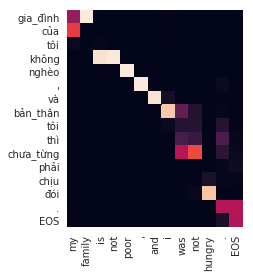

In [92]:
n = 5
draw(attention_scores[n],pred_corpus[n],src_corpus[n])

In [1]:
print("hello")

hello


In [ ]:
train['en_len'] = train['en_idized'].apply(lambda x: len(x))

a = pd.DataFrame()